# A Comparative Study of Input Features and Augmentation Techniques in CNN-CRNN models for Environmental Sound Classification

Project developed by: Laura Legrottaglie, id:2073222

Department of Mathematics, University of Padua

## Imports and setting the enviroment

In [ ]:
! pip install pydub

In [ ]:
! pip install librosa

In [ ]:
#Imports
from google.colab import drive
import IPython.display as ipd
from IPython.display import Audio
import scipy.io.wavfile as wav
import os
import librosa
import random
import pydub
import numpy as np
import pandas as pd
import pickle
import gc
import ast
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import utils
import pickle
import random
import time
import absl.logging
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Human_Data_Analytics/Project'

/content/drive/MyDrive/Human_Data_Analytics/Project


In [ ]:
# TensorFlow level to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
absl.logging.set_verbosity('fatal')
import tensorflow as tf

In [ ]:
# Set seed for reproducibility
random.seed(42)
# Set seed for NumPy
np.random.seed(42)
# Set seed for TensorFlow
tf.random.set_seed(42)

##Data preparation

In [ ]:
#Listening to a randomly chosen audio
audio_directory= "audio/"
files = os.listdir(audio_directory)
summary = pd.read_csv('esc50.csv')
summary = summary.loc[:,['filename','fold','category','esc10']]
random_file = random.choice(files)
random_path = audio_directory + random_file
category = summary.loc[summary['filename']==random_file,'category']
print("The sound in the randomly selected file is ", category.values[0])
ipd.Audio(random_path)

The sound in the randomly selected file is  pouring_water


In [ ]:
#Preparing the audio files. The audios files are in 16-bit PCM format,
#where the audio values are stored as integers.
#In addition to fix the length of the audio to 5 s, we need to convert
#the audio values into float numbers between -1.00 and 1.00

def preprocess_audio(file_name):
    file_path = audio_directory + file_name
    data = pydub.AudioSegment.silent(duration=5000)
    data = data.overlay(pydub.AudioSegment.from_file(file_path).set_frame_rate(22050).set_channels(1)[0:5000])
    raw_audio = (np.frombuffer(data.raw_data, dtype="int16") + 0.5) / (0x7FFF + 0.5)
    metadata = summary.loc[summary['filename']==file_name,['category','fold','esc10','filename']].values[0]
    return raw_audio,metadata

audios=[]
for filepath in os.listdir(audio_directory):
    audios.append(preprocess_audio(filepath))

#Constructing a dataset with the following columns:
#raw_audio: waveform of the audio file
#category: category of the audio file
#esc10: True if the audio belongs to the ESC-10 dataset
#file_name: name of the file
#augmented: False for all the original audios

audio_data = {'raw_audio':[item[0] for item in audios],'category':[item[1][0] for item in audios],'fold':[item[1][1] for item in audios],
              'esc10':[item[1][2] for item in audios],'file_name':[item[1][3] for item in audios]}

audio_df = pd.DataFrame(audio_data)
audio_df['augmented']= False
audio_df.drop('file_name', axis=1)

In [ ]:
del audios, audio_data
gc.collect()

In [ ]:
#audio_df.to_pickle('audio_data.pkl')
audio_df = pd.read_pickle('audio_data.pkl')

In [ ]:
#Visualizing the dataset
audio_df.head()

raw_audio         category  fold  \
0  [-0.008377203021286335, -0.014572365911345083,...            sheep     1   
1  [0.005050736247806516, -0.0037689784084840162,...         crickets     2   
2  [0.011703669794766156, 0.003036545357442588, -...        breathing     2   
3  [0.00010681315327687495, -0.001480125123979552...  keyboard_typing     3   
4  [-0.04640268558785382, -0.04301518272678721, -...         airplane     1   

   esc10          file_name  augmented  
0  False    1-49409-B-8.wav      False  
1  False   2-80844-A-13.wav      False  
2  False   2-84965-A-23.wav      False  
3  False  3-153444-A-32.wav      False  
4  False   1-43807-D-47.wav      False

## Visualizing extracted features

In [ ]:
#Create a list of random audios for visualization
sr = 22050
list_audio = []
list_category= []
for i in range(5):
    index = random.randint(0, audio_df.shape[0])
    category = audio_df.loc[index,'category']
    while category in list_category:
        index = random.randint(0, audio_df.shape[0])
        category = audio_df.loc[index,'category']
    list_category.append(category)
    raw_audio = audio_df.loc[index,'raw_audio']
    list_audio.append(raw_audio)

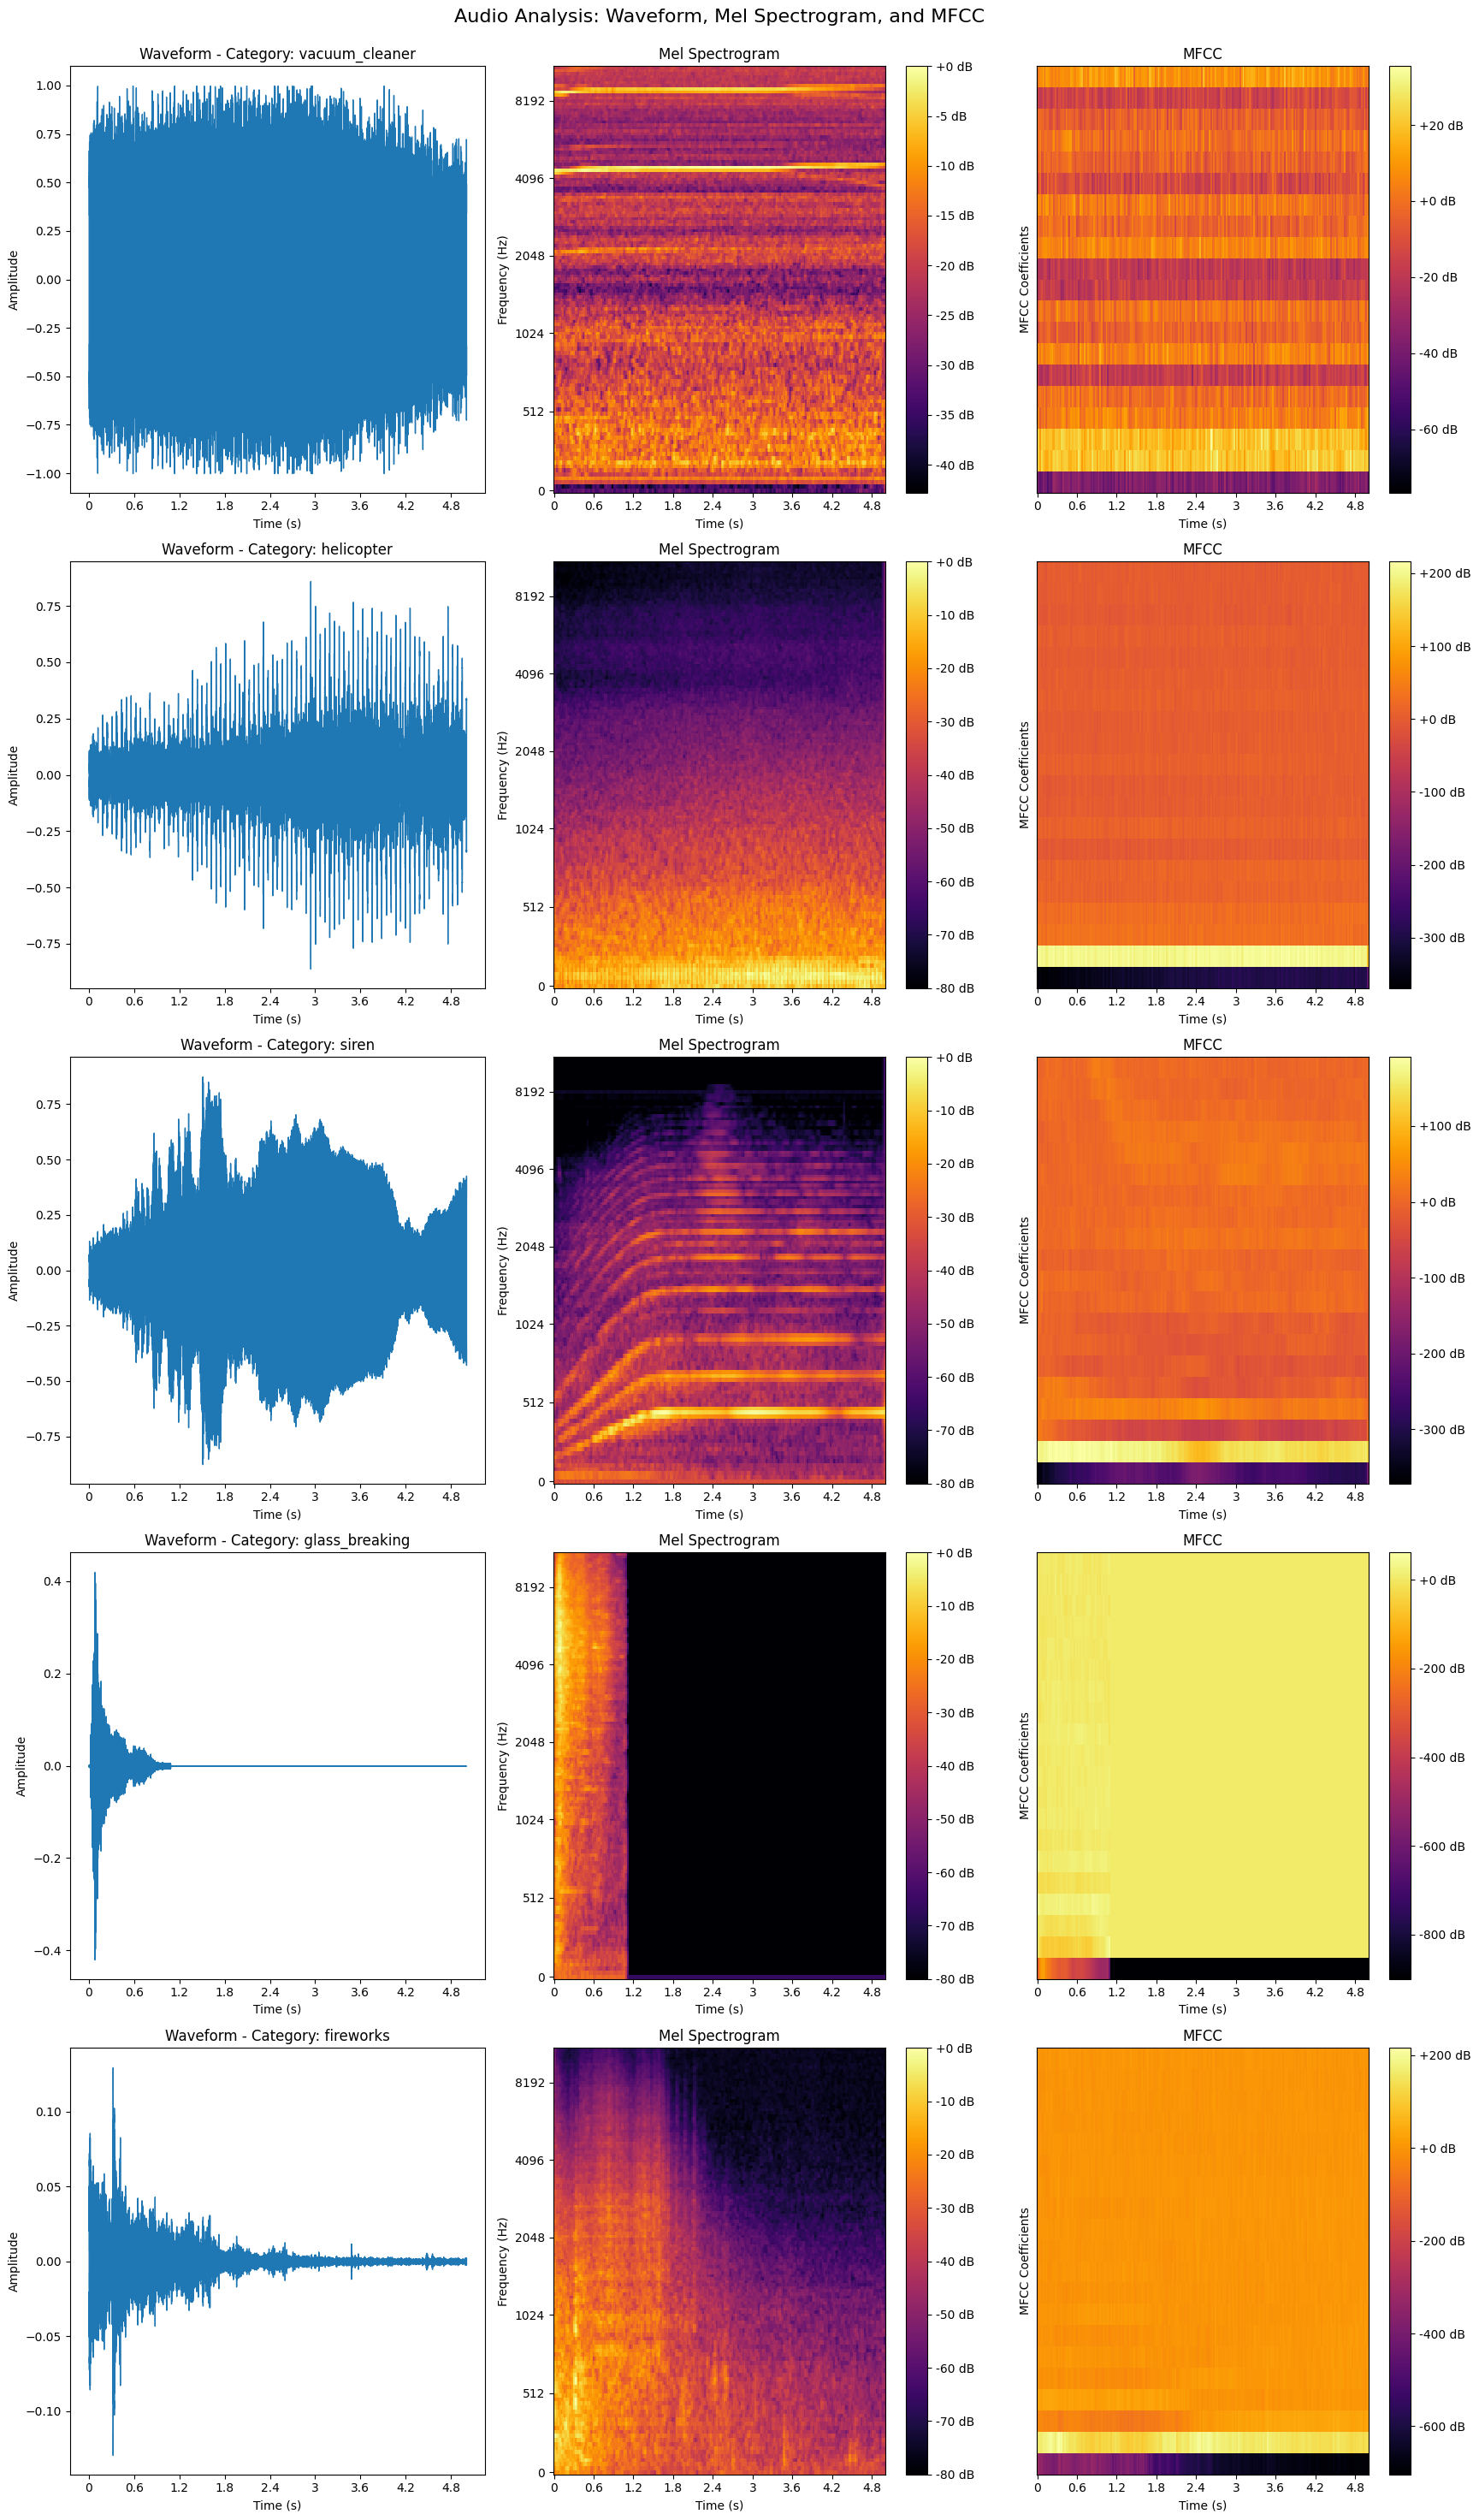

In [ ]:
#Plotting the waveforms, the melspectograms and 20 MFCC coefficients of 5 randomly selected audios
num_audios = len(list_audio)
rows = num_audios
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
for i in range(num_audios):
    raw_audio = list_audio[i]
    category = list_category[i]

    # Waveform
    ax_wave = axes[i, 0]
    ax_wave.set_title("Waveform - Category: " +category)
    librosa.display.waveshow(raw_audio, sr=sr, ax=ax_wave)
    ax_wave.set_ylabel('Amplitude')
    ax_wave.set_xlabel('Time (s)')
    # Mel Spectrogram
    ax_mel = axes[i, 1]
    ax_mel.set_title("Mel Spectrogram")
    melspec = librosa.feature.melspectrogram(y=raw_audio, sr=sr)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    img_mel = librosa.display.specshow(logspec, x_axis="time", y_axis="mel", sr=sr, ax=ax_mel, cmap='inferno')
    ax_mel.set_ylabel("Frequency (Hz)")
    ax_mel.set_xlabel("Time (s)")
    fig.colorbar(img_mel, ax=ax_mel, format='%+2.0f dB')
    # MFCC
    ax_mfcc = axes[i, 2]
    ax_mfcc.set_title("MFCC")
    mfcc = librosa.feature.mfcc(y=raw_audio, sr=sr, n_mfcc=20, n_fft=1024, hop_length=512)
    img_mfcc = librosa.display.specshow(mfcc, x_axis="time", sr=sr, hop_length=512, ax=ax_mfcc, cmap='inferno')
    ax_mfcc.set_ylabel("MFCC Coefficients")
    ax_mfcc.set_xlabel("Time (s)")
    fig.colorbar(img_mfcc, ax=ax_mfcc, format='%+2.0f dB')

# Adjust layout
plt.tight_layout(rect=[0.03, 0, 1, 0.97])
fig.suptitle("Audio Analysis: Waveform, Mel Spectrogram, and MFCC", fontsize=16, y=0.98)
plt.show()

## Data augmentation

In [ ]:
#Augmentation 1: adding white noise to the audio
def augment_noise(raw_audio):
    size = len(raw_audio)
    augmented_audio = raw_audio + 0.005*np.random.randn(size)
    return augmented_audio

In [ ]:
#Adding row to the original audio dataset
def add_row(batch_df, audio_vector, index, augmented):
    row_df = pd.DataFrame({
        'raw_audio':[audio_vector],
        'category': [batch_df.loc[index, 'category']],
        'esc10': [batch_df.loc[index, 'esc10']],
        'file_name': [batch_df.loc[index, 'file_name']],
        'fold': [batch_df.loc[index, 'fold']],
        'augmented': [augmented],
    })
    return row_df

In [ ]:
#Function defined to construct new datasets
#The augmented audios are added to the original dataset and then the dataframe is saved in a pickle file.
#The new dataset has 10000 samples. The possible augmentation techniques are:
# 1) White noise injection, scaled down by a factor of 0.05
# 2) Pitch shifting: each sample is modified to shift the pitch by 4 different semitones: -2, -1, 1, 2.
# 3) Combination of the two: after modifying the pitch of the audio randomly chosen from the set {-2,-1,1,2}, white noise is added

def construct_dataset(df, variant, type_augmentation, save_path="10000pitch_df.pkl"):
    sample_rate = 22050
    batch_size= 100
    header_written=False
    open(save_path, 'wb').close()
    for i in range(0, df.shape[0], batch_size):
        final_df = pd.DataFrame()
        gc.collect()
        batch_files = df.iloc[i:i + batch_size,:].reset_index(drop=True)
        for j in range(0, batch_files.shape[0]):
            raw_audio = batch_files.loc[j,'raw_audio']
            category = batch_files.loc[j, 'category']
            new_row = add_row(batch_files,raw_audio,j,False)
            final_df = pd.concat([final_df,new_row])
            if type_augmentation == "noise":
                if variant == 'ESC-10': # correggere solo quelli con esc10=True
                    num_augment = 10
                else:
                    num_augment=4
                for k in range(num_augment):
                    augmented_audio = augment_noise(raw_audio)
                    new_row = add_row(batch_files,augmented_audio,j,True)
                    final_df = pd.concat([final_df,new_row])
            elif type_augmentation == "pitch_shift":
                for semitone in [-2,-1, 1,2]:
                    shifted_audio = librosa.effects.pitch_shift(y=raw_audio, sr=sample_rate, n_steps=semitone)
                    new_row = add_row(batch_files,shifted_audio,j,True)
                    final_df = pd.concat([final_df,new_row])
            else:
                num_augment = 3
                for k in range(num_augment):
                  semitones = [-2,-1,1,2]
                  random_semitone = np.random.choice(semitones)
                  shifted_audio = librosa.effects.pitch_shift(y=raw_audio, sr=sample_rate, n_steps=random_semitone)
                  augmented_audio = shifted_audio + 0.005*np.random.randn(len(shifted_audio))
                  new_row = add_row(batch_files,augmented_audio,j,True)
                  final_df = pd.concat([final_df,new_row])
        with open(save_path, 'ab') as f:
            pickle.dump(final_df, f)
    return

In [ ]:
#Reading the pickle file
data_frames = []
with open('10000pitch_df.pkl', 'rb') as f:
    while True:
        try:
            data_frames.append(pickle.load(f))
        except EOFError:
            break

final_df = pd.concat(data_frames, ignore_index=True)


#Encoding the categories in the dataset
label_encoder = LabelEncoder()
final_df.loc[:,'label_encoded']= label_encoder.fit_transform(final_df['category'])

In [ ]:
#Visualizing the new dataset
final_df

raw_audio  category  esc10  \
0     [-0.008377203021286335, -0.014572365911345083,...     sheep  False   
1     [-0.007601415738463402, -0.013386983424425125,...     sheep  False   
2     [-0.007799303159117699, -0.013983913697302341,...     sheep  False   
3     [-0.007731104269623756, -0.015253083780407906,...     sheep  False   
4     [-0.007573341950774193, -0.015953723341226578,...     sheep  False   
...                                                 ...       ...    ...   
9995  [4.5777065690089265e-05, 4.5777065690089265e-0...  sneezing   True   
9996  [4.300718501326628e-05, 4.713806265499443e-05,...  sneezing   True   
9997  [4.308708957978524e-05, 4.665987580665387e-05,...  sneezing   True   
9998  [4.1836246964521706e-05, 4.6686815039720386e-0...  sneezing   True   
9999  [4.060234277858399e-05, 4.724087193608284e-05,...  sneezing   True   

             file_name  fold  augmented  label_encoded  
0      1-49409-B-8.wav     1      False             39  
1      1-49409-B-8.wav     1       True             39  
2      1-49409-B-8.wav     1       True             39  
3      1-49409-B-8.wav     1       True             39  
4      1-49409-B-8.wav     1       True             39  
...                ...   ...        ...            ...  
9995  2-82538-A-21.wav     2      False             41  
9996  2-82538-A-21.wav     2       True             41  
9997  2-82538-A-21.wav     2       True             41  
9998  2-82538-A-21.wav     2       True             41  
9999  2-82538-A-21.wav     2       True             41  

[10000 rows x 7 columns]

## Feature extraction

In [ ]:
def prepare_input(audio, type_input, sr, n_bands=60,augment = True):
    #Normalize audio
    audio = audio * (1/np.max(np.abs(audio)))

    #Compute the log-melspectogram with window size=1024, hop_length=512 and number of filters=60
    melspec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=512, n_mels=n_bands)
    logspec = librosa.power_to_db(melspec) #shape (60 x 216)

    #Normalize the logspectogram before computing the delta feature
    logspec_normalized = (logspec - np.min(logspec)) / (np.max(logspec) - np.min(logspec))
    delta_features = librosa.feature.delta(logspec_normalized)


    logspec = logspec[..., np.newaxis]  # shape (60 x 216 x 1)
    delta_features = delta_features[..., np.newaxis]  # shape (60 x 216 x 1)

    #Concatenate logspec and delta_features along the channel axis
    combined_features = np.concatenate((logspec, delta_features), axis=-1)  # shape (60 x 216 x 2)

    return combined_features

In [ ]:
#Computing 20 MFCC coefficients with window_size=1024 and hop_length=512

def construct_cepstral_coefficients(audio, sr=22050):
    # Normalize audio
    audio = audio * (1 / np.max(np.abs(audio)))

    # Compute MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=1024, hop_length=512)

    # Compute energy coefficient
    window_size = 1024
    hop_length = 512
    energy = [np.sum(audio[i:i + window_size]**2) for i in range(0, len(audio), hop_length)]

    # Append energy to MFCC
    mfcc = np.concatenate((mfcc, np.reshape(energy, (1, len(energy)))), axis=0)

    # Compute delta features
    delta = librosa.feature.delta(mfcc)
    delta_delta = librosa.feature.delta(mfcc, order = 2)

    # Reshape features
    mfcc = mfcc[..., np.newaxis]
    delta = delta[..., np.newaxis]
    delta_delta = delta_delta[..., np.newaxis]

    # Concatenate features along the last axis
    combined_features = np.concatenate((mfcc, delta, delta_delta), axis=-1)

    return combined_features

## Dataset splitting for 5-fold cross validation

In [ ]:
#Splitting the dataset into training, validation and testing considering the original
#folds suddivision in order to perform 5-fold cross validation.
#In the cross validation setting, 3 folds are used for training, one for validation and one for testing
#The augmented data are only used for training

def split_dataset(df, val_fold, test_fold, type_input, mixup=False):

  #Training dataset
  train_df = df.loc[~((df['fold']==val_fold) | (df['fold']==test_fold)),:]
  y_train = train_df['label_encoded'].values
  X_train = []
  if type_input == "melspec":
    for audio in train_df['raw_audio']:
      X_train.append(prepare_input(audio, type_input, sr=22050, n_bands=60))

  elif type_input == "raw_audio":
    for audio in train_df['raw_audio']:
        #Normalize the audio
        audio = (audio - np.mean(audio)) / np.std(audio)
        X_train.append(audio[:, np.newaxis])

  else: #(type_input = "mfcc")
    for audio in train_df['raw_audio']:
      X_train.append(construct_cepstral_coefficients(audio))

  X_train = np.array(X_train)


  #Validation dataset: all the not-augmented audios contained in the val_fold
  val_df = df.loc[(df['fold']==val_fold) & (df['augmented']==False),:]
  y_val = val_df['label_encoded'].reset_index(drop=True).values
  X_val = []
  if type_input == "melspec":
    for audio in val_df['raw_audio']:
      X_val.append(prepare_input(audio, type_input, sr=22050, n_bands=60))

  elif type_input == "raw_audio":
    for audio in val_df['raw_audio']:
        audio = (audio - np.mean(audio)) / np.std(audio)
        X_val.append(audio[:, np.newaxis])

  else: #(type_input = "mfcc")
    for audio in val_df['raw_audio']:
      X_val.append(construct_cepstral_coefficients(audio))

  X_val = np.array(X_val)

  #Test dataset: all the not-augmented audios contained in test_fold
  test_df = df.loc[(df['fold']==test_fold) & (df['augmented']==False),:]
  y_test = test_df['label_encoded'].values
  X_test = []
  if type_input=="melspec":
    for audio in test_df['raw_audio']:
      X_test.append(prepare_input(audio, type_input, sr=22050, n_bands=60))

  elif type_input == "raw_audio":
    for audio in test_df['raw_audio']:
        audio = (audio - np.mean(audio)) / np.std(audio)
        X_test.append(audio[:, np.newaxis])

  else: #(type_input = "mfcc")
    for audio in test_df['raw_audio']:
      X_test.append(construct_cepstral_coefficients(audio))
  X_test = np.array(X_test)

  if mixup == True:
      num_classes = 50
      y_train = utils.to_categorical(y_train, num_classes)
      y_val = utils.to_categorical(y_val,num_classes)
      y_test = utils.to_categorical(y_test, num_classes)

  return X_train, y_train, X_val, y_val, X_test, y_test

## Mix up augmentation

In [ ]:
class MixupGenerator():

    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True, num_mixups=8):
        self.x_train = x_train
        self.y_train = y_train
        # Number of samples in each half-batch
        self.batch_size = batch_size
        # Parameter for Beta distribution
        self.alpha = alpha
        #For shuffling data at each epoch
        self.shuffle = shuffle
        #Number of training samples
        self.sample_num = len(x_train)
        # Number of mixups per batch: this controls how many new mixed samples are generated from each pair of half-batches
        self.num_mixups = num_mixups

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2)) #how many full batches can be created from the data
            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)
                yield x, y

    #Get and shuffling data indexes
    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)
        if self.shuffle:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, batch_ids):
        # Split the batch into two halves
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]

        # Perform mixup num_mixups times
        x_mixed = []
        y_mixed = []
        for _ in range(self.num_mixups):
            l = np.random.beta(self.alpha, self.alpha, self.batch_size)
            x_l = l.reshape(self.batch_size, 1, 1, 1)
            y_l = l.reshape(self.batch_size, 1)

            x = x1 * x_l + x2 * (1 - x_l)
            y = y1 * y_l + y2 * (1 - y_l)

            x_mixed.append(x)
            y_mixed.append(y)

        x_mixed = np.concatenate(x_mixed, axis=0)
        y_mixed = np.concatenate(y_mixed, axis=0)

        return x_mixed, y_mixed

## Training and evaluation set up

In [ ]:
#Defining a Callback to print validation accuracy only every 10 epochs
class EpochOutputControl(Callback):

    def __init__(self, frequency=10):
        super(EpochOutputControl, self).__init__()
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            print(f"Epoch {epoch+1} - Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, "f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

In [ ]:
#Training the model based on the type_input and perform 5-fold cross validation

def train_and_evaluate(model_name,input_shape, type_input, mixup = False, original_data = False):

    figure, axis = plt.subplots(5,2,figsize=(20,15))
    num_folds = 5
    folds = [1,2,3,4,5]
    sampling_rate = 22050

    fold_models_path=[]

    accuracies=[]
    training_times = []
    all_predictions = []
    true_labels=[]

    for i in range(num_folds):
        val_fold = folds[i]
        test_fold = folds[(i+1) % num_folds]
        print(f"Processing Fold {i+1} - Validation Fold: {val_fold}, Test Fold: {test_fold}")

        if mixup == True and original_data == True:
          #Encoding the categories in the original dataset
            label_encoder = LabelEncoder()
            audio_df.loc[:,'label_encoded']= label_encoder.fit_transform(audio_df['category'])
            X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(audio_df, val_fold, test_fold, type_input, mixup=True)
        elif mixup == True and original_data == False:
            X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(final_df, val_fold, test_fold, type_input)
        else:
            X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(final_df, val_fold, test_fold, type_input)

        model = model_name(input_shape, 'ESC-50')
        output_control = EpochOutputControl(frequency=10)

        if type_input == "melspec":
            if mixup == False:
                adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
                model.compile(optimizer=adam_optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
                start_time = time.time()
                history_model = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=50,batch_size=50, verbose=0, callbacks=[output_control])
                end_time = time.time()
           else:
                batch_size_mix = 10
                num_mixups = 8
                total_samples_per_epoch = 9200
                effective_batch_size = batch_size_mix * num_mixups
                steps_per_epoch = int(np.ceil(total_samples_per_epoch / effective_batch_size))

                adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
                model.compile(optimizer=adam_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
                reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=0.0001, verbose=1)
                training_generator = MixupGenerator(X_train, y_train,batch_size=batch_size_mix,alpha=0.2,shuffle=True,num_mixups=num_mixups)()

                start_time = time.time()
                history_model = model.fit(training_generator,steps_per_epoch=steps_per_epoch,validation_data=(X_val, y_val),epochs=150,batch_size=50, verbose=0, shuffle = True, callbacks=[output_control, reduce_lr])
                end_time = time.time()

        elif type_input == "raw_audio":
            reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
            model.compile(optimizer ="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])
            start_time = time.time()
            history_model = model.fit(X_train,y_train,validation_data = (X_val,y_val),epochs=50,verbose=0,callbacks=[reduce_lr, output_control])
            end_time = time.time()

        else: #type_input = "mfcc"
          if mixup == False:
              adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
              model.compile(optimizer=adam_optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
              start_time = time.time()
              history_model = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=300,batch_size=50, verbose=0, callbacks=[reduce_lr,early_stopping,output_control])
              end_time = time.time()
          else:
              batch_size_mix = 10
              num_mixups = 8
              total_samples_per_epoch = 9200
              effective_batch_size = batch_size_mix * num_mixups
              steps_per_epoch = int(np.ceil(total_samples_per_epoch / effective_batch_size))
              adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
              model.compile(optimizer=adam_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
              training_generator = MixupGenerator(X_train, y_train,batch_size=batch_size_mix,alpha=0.2,shuffle=True,num_mixups=num_mixups)()
              start_time = time.time()
              history_model = model.fit(training_generator,steps_per_epoch=steps_per_epoch,validation_data=(X_val, y_val),epochs=150,batch_size=50, verbose=0, shuffle = True, callbacks=[output_control])
              end_time = time.time()

        elapsed_time = end_time - start_time
        training_times.append(elapsed_time)

        predictions = model.predict(X_test)
        all_predictions.append(list(predictions))

        true_labels.append(y_test)

        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
        accuracies.append(test_accuracy)

        print(f"Fold {test_fold} - Test Accuracy: {test_accuracy}")


        axis[i,0].plot(history_model.history['loss'], label='Train loss')
        axis[i,0].plot(history_model.history['val_loss'], label='Val loss')
        axis[i,0].set_xlabel('Epoch')
        axis[i,0].set_ylabel('Loss')
        axis[i,0].set_title(f'Loss for Val fold {val_fold} and test fold {test_fold}')
        axis[i,0].legend()


        axis[i,1].plot(history_model.history['accuracy'], label='Train accuracy')
        axis[i,1].plot(history_model.history['val_accuracy'], label='Val accuracy')
        axis[i,1].set_xlabel('Epoch')
        axis[i,1].set_ylabel('Accuracy')
        axis[i,1].set_title(f'Accuracy for Val fold {val_fold} and test fold {test_fold}')
        axis[i,1].legend()

    mean_test_accuracy = np.mean(accuracies)
    std_test_accuracy = np.std(accuracies)
    mean_training_time = np.mean(training_times)

    print(f"\nMean Test Accuracy over {num_folds} folds: {mean_test_accuracy}")
    print(f"\nStd Test Accuracy over {num_folds} folds: {std_test_accuracy}")
    print(f"Mean Training Time over {num_folds} folds: {mean_training_time:.2f} seconds")

    plt.tight_layout()
    plt.show()

    return mean_test_accuracy,mean_training_time,true_labels,all_predictions

## CNN on the log-mel spectrograms

In [ ]:
def MelNet(input_shape, variant):
    # Define the input layer
    X_input = tf.keras.Input(shape=input_shape)

    # First Convolutional Block
    X = tf.keras.layers.Conv2D(64, kernel_size=3)(X_input)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    # Second Convolutional Block
    X = tf.keras.layers.Conv2D(128, kernel_size=3)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    # Third Convolutional Block
    X = tf.keras.layers.Conv2D(256, kernel_size=3)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    # Fourth Convolutional Block
    X = tf.keras.layers.Conv2D(256, kernel_size=3)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    # Global Max Pooling
    X = tf.keras.layers.GlobalMaxPooling2D()(X)

    # Fully Connected Layer
    X = tf.keras.layers.Dense(256, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.5)(X)

    # Output Layer
    if variant == 'ESC-10':
        X_output = tf.keras.layers.Dense(10, activation='softmax')(X)
    else:
        X_output = tf.keras.layers.Dense(50, activation='softmax')(X)

    # Define the model
    model = tf.keras.Model(inputs=X_input, outputs=X_output, name="MelNet")

    return model

# Example usage:
Mel_net = MelNet((60, 216, 2), 'ESC-50')
Mel_net.summary()

Model: "MelNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 214, 64)    │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 214, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 58, 214, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 107, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 107, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 105, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 105, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 105, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 25, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 25, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 23, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 23, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 23, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 23, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,041,778 (3.97 MB)

 Trainable params: 1,040,370 (3.97 MB)

 Non-trainable params: 1,408 (5.50 KB)

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 1.8760, Accuracy: 0.4358, Val Loss: 2.2610, Val Accuracy: 0.3950
Epoch 20 - Loss: 0.9911, Accuracy: 0.7008, Val Loss: 1.3570, Val Accuracy: 0.5950
Epoch 30 - Loss: 0.5667, Accuracy: 0.8167, Val Loss: 1.2936, Val Accuracy: 0.6250
Epoch 40 - Loss: 0.3866, Accuracy: 0.8867, Val Loss: 1.2764, Val Accuracy: 0.6300
Epoch 50 - Loss: 0.2636, Accuracy: 0.9167, Val Loss: 1.1568, Val Accuracy: 0.6825
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Fold 2 - Test Accuracy: 0.6499999761581421
Processing Fold 2 - Validation Fold: 2, Test Fold: 3
Epoch 10 - Loss: 2.0840, Accuracy: 0.3858, Val Loss: 2.3321, Val Accuracy: 0.4025
Epoch 20 - Loss: 1.0378, Accuracy: 0.6700, Val Loss: 1.7481, Val Accuracy: 0.5150
Epoch 30 - Loss: 0.5784, Accuracy: 0.8125, Val Loss: 1.5161, Val Accuracy: 0.5650
Epoch 40 - Loss: 0.3643, Accuracy: 0.8900, Val Loss: 1.2613, Val Accuracy: 0.6525
Epoch 50 - Loss: 0.2689, Accuracy: 0.9192, Val Loss: 1.3984, Val Accuracy

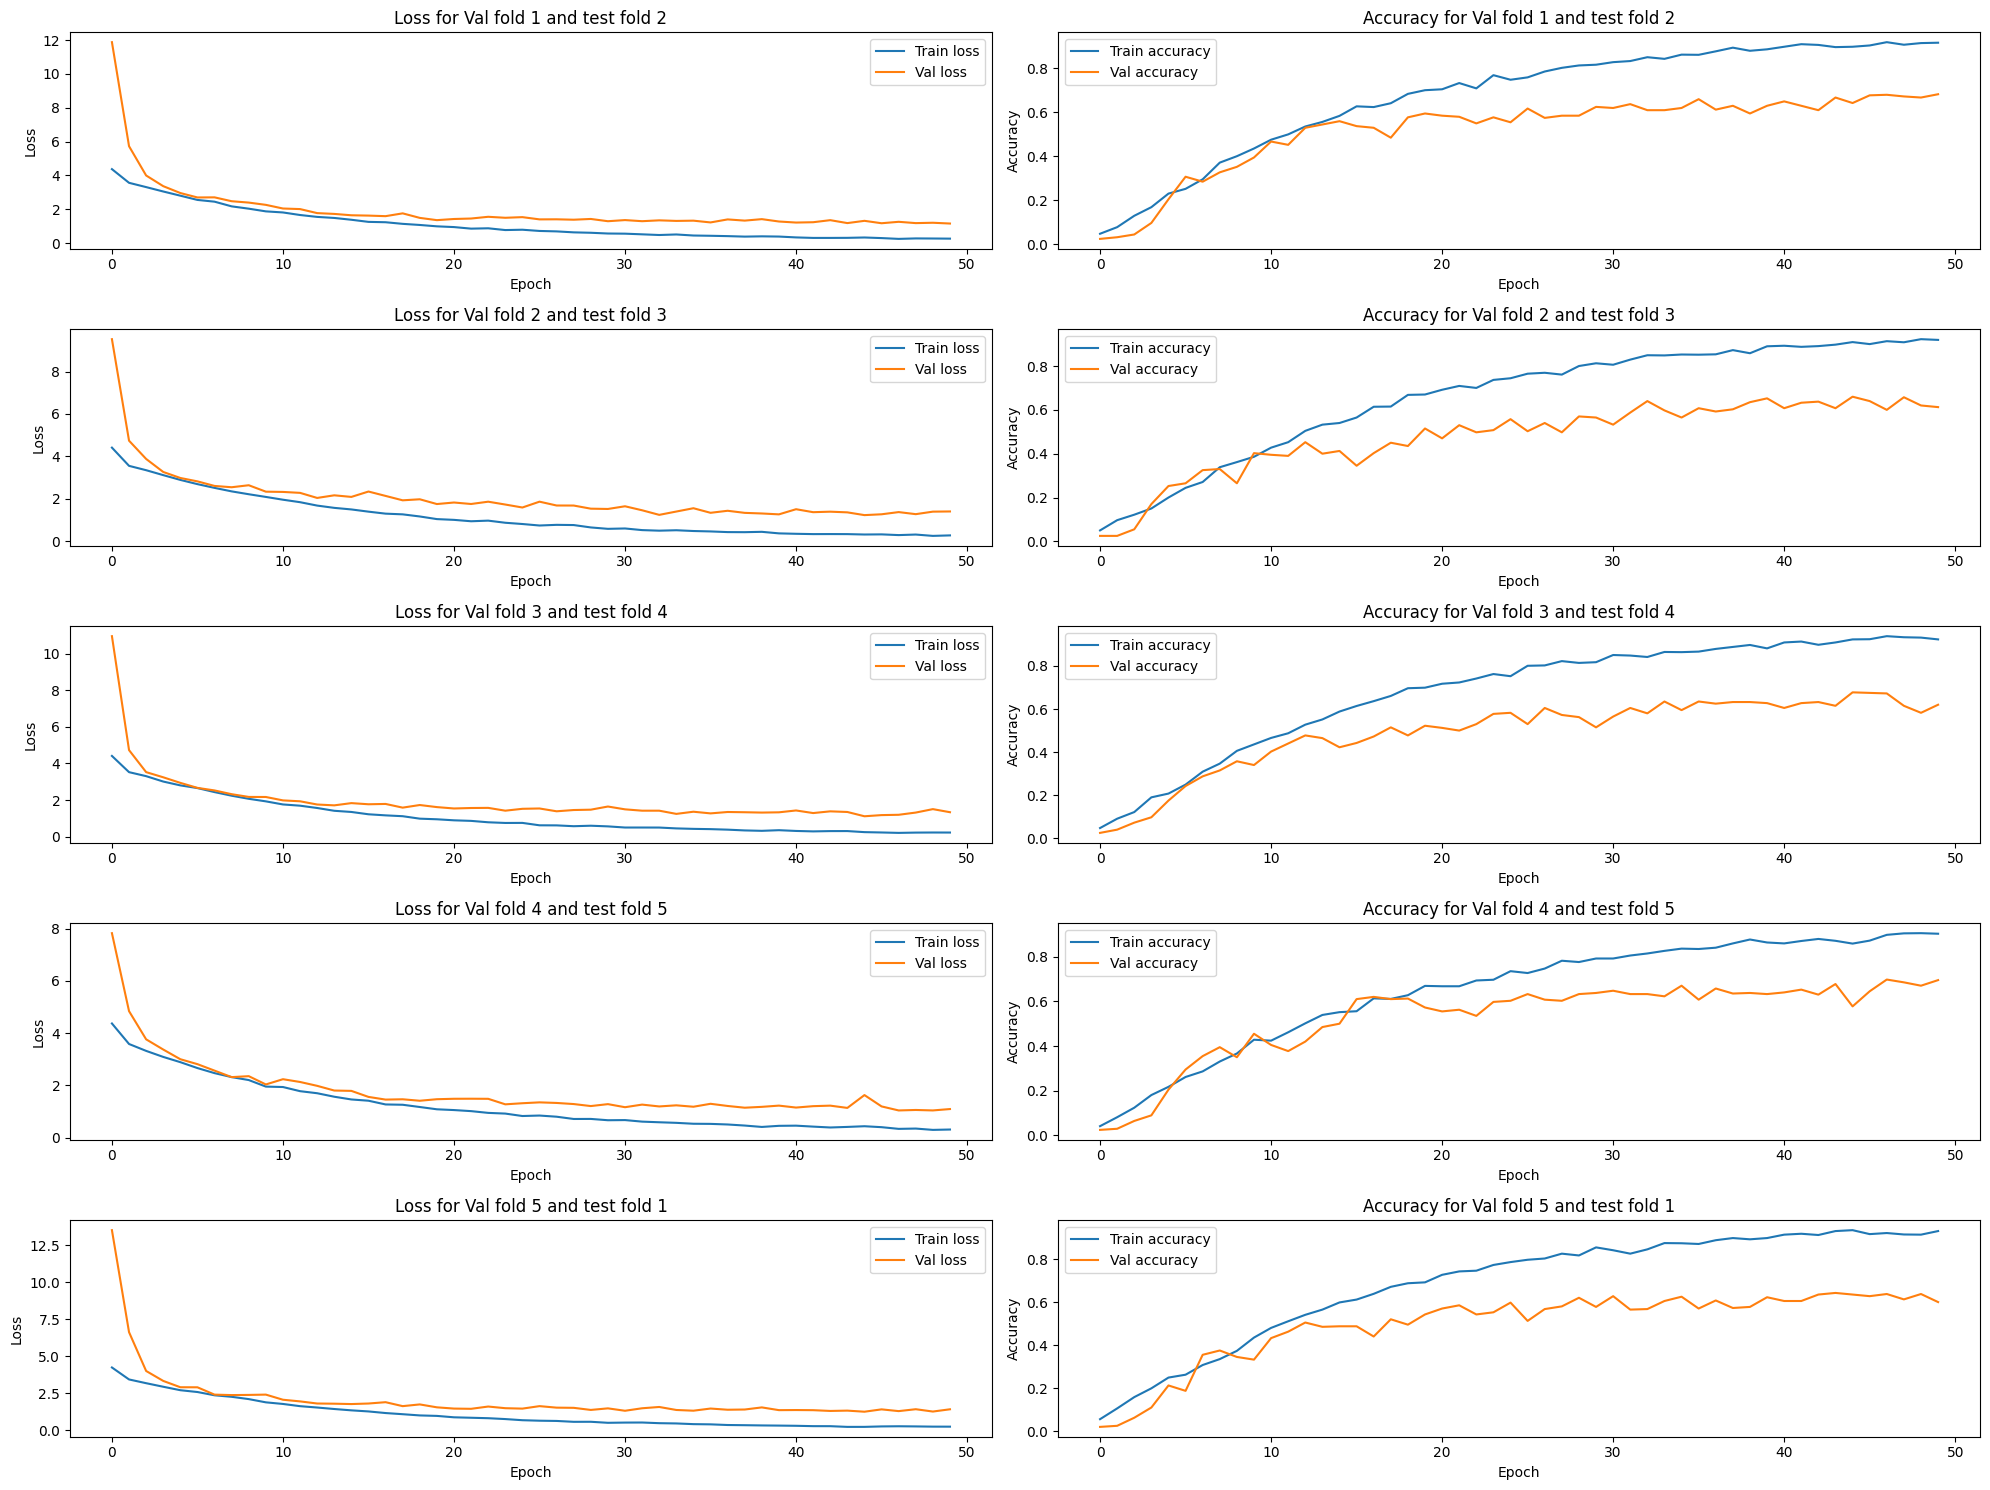

In [ ]:
#Training and evaluation on the standard dataset
accuracy_no_aug, time_no_aug, y_test, preds = train_and_evaluate(MelNet, input_shape= (60, 216 ,2), type_input= "melspec")

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 0.4247, Accuracy: 0.8597, Val Loss: 1.2655, Val Accuracy: 0.6775
Epoch 20 - Loss: 0.1278, Accuracy: 0.9615, Val Loss: 1.2459, Val Accuracy: 0.7000
Epoch 30 - Loss: 0.0677, Accuracy: 0.9807, Val Loss: 1.5395, Val Accuracy: 0.6650
Epoch 40 - Loss: 0.0529, Accuracy: 0.9835, Val Loss: 1.8075, Val Accuracy: 0.6650
Epoch 50 - Loss: 0.0476, Accuracy: 0.9848, Val Loss: 1.8555, Val Accuracy: 0.6550
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Fold 2 - Test Accuracy: 0.6600000262260437
Processing Fold 2 - Validation Fold: 2, Test Fold: 3
Epoch 10 - Loss: 0.3970, Accuracy: 0.8723, Val Loss: 1.2680, Val Accuracy: 0.6675
Epoch 20 - Loss: 0.1126, Accuracy: 0.9642, Val Loss: 1.4529, Val Accuracy: 0.6500
Epoch 30 - Loss: 0.0605, Accuracy: 0.9793, Val Loss: 1.6279, Val Accuracy: 0.6900
Epoch 40 - Loss: 0.0638, Accuracy: 0.9780, Val Loss: 1.6547, Val Accuracy: 0.6725
Epoch 50 - Loss: 0.0479, Accuracy: 0.9840, Val Loss: 1.8642, Val Accuracy

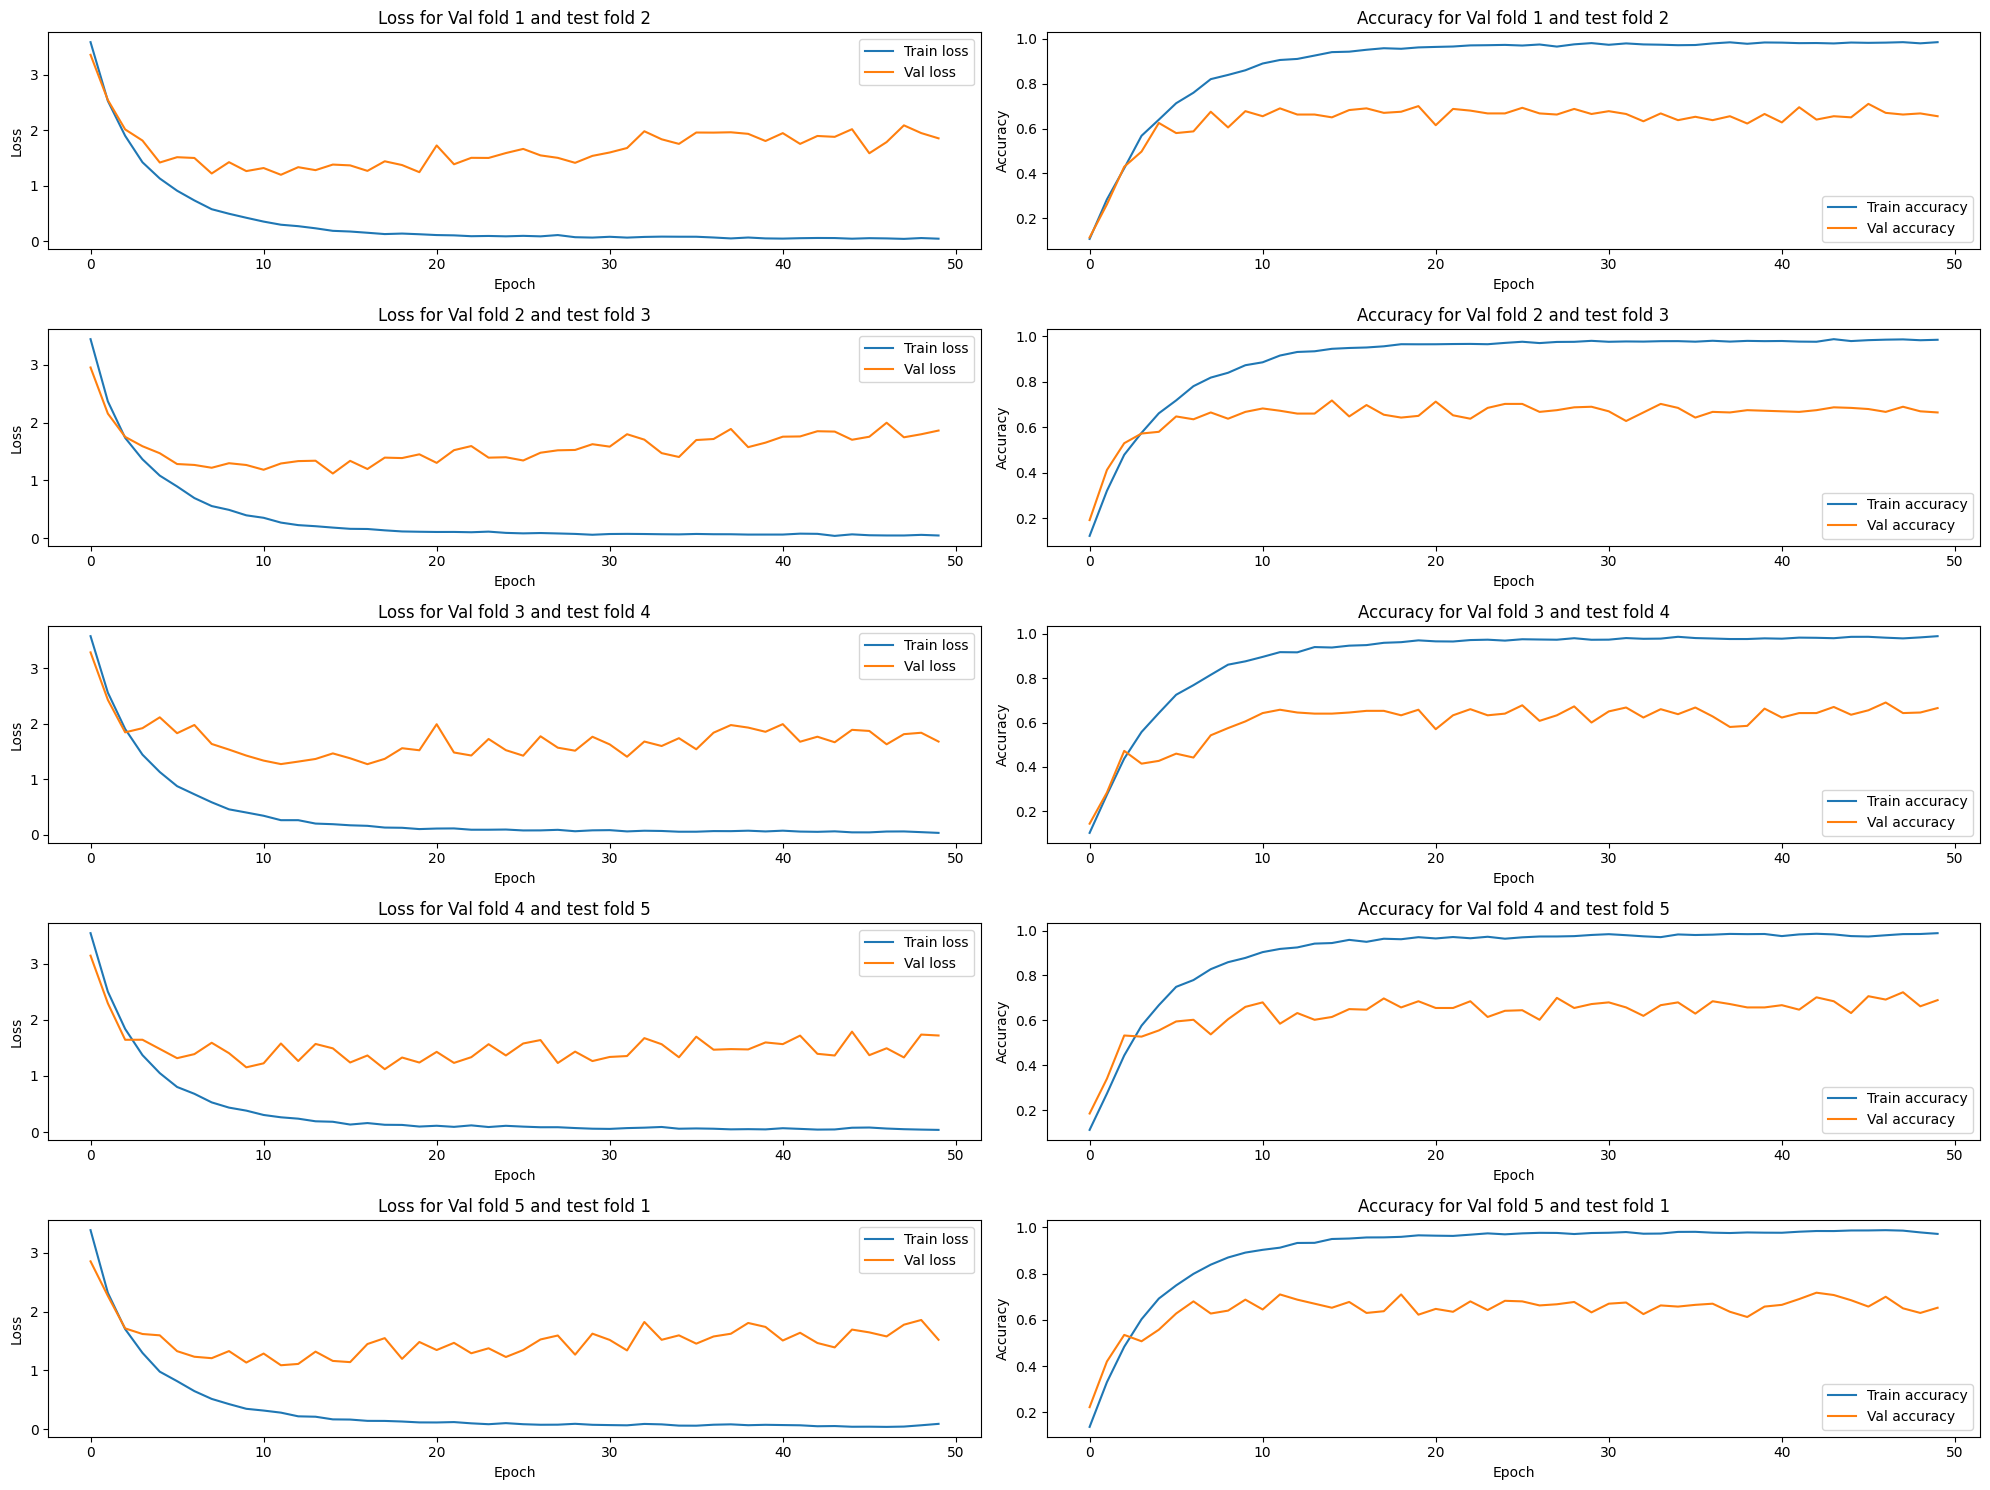

In [ ]:
#Training and evaluation on the augmented noisy dataset
noise_accuracy, noise_time, y_test, noise_preds = train_and_evaluate(MelNet, input_shape= (60, 216 ,2), type_input= "melspec")

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 0.5760, Accuracy: 0.8180, Val Loss: 1.6168, Val Accuracy: 0.5300
Epoch 20 - Loss: 0.2095, Accuracy: 0.9292, Val Loss: 1.4461, Val Accuracy: 0.6450
Epoch 30 - Loss: 0.1251, Accuracy: 0.9582, Val Loss: 1.5463, Val Accuracy: 0.6400
Epoch 40 - Loss: 0.0968, Accuracy: 0.9673, Val Loss: 1.7621, Val Accuracy: 0.6300
Epoch 50 - Loss: 0.0757, Accuracy: 0.9758, Val Loss: 1.5034, Val Accuracy: 0.6850
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Fold 2 - Test Accuracy: 0.7049999833106995
Processing Fold 2 - Validation Fold: 2, Test Fold: 3
Epoch 10 - Loss: 0.5379, Accuracy: 0.8250, Val Loss: 1.2170, Val Accuracy: 0.6650
Epoch 20 - Loss: 0.2091, Accuracy: 0.9265, Val Loss: 1.4712, Val Accuracy: 0.6625
Epoch 30 - Loss: 0.1419, Accuracy: 0.9510, Val Loss: 1.4658, Val Accuracy: 0.6750
Epoch 40 - Loss: 0.0965, Accuracy: 0.9660, Val Loss: 1.5633, Val Accuracy: 0.6950
Epoch 50 - Loss: 0.0685, Accuracy: 0.9768, Val Loss: 1.6970, Val Accuracy

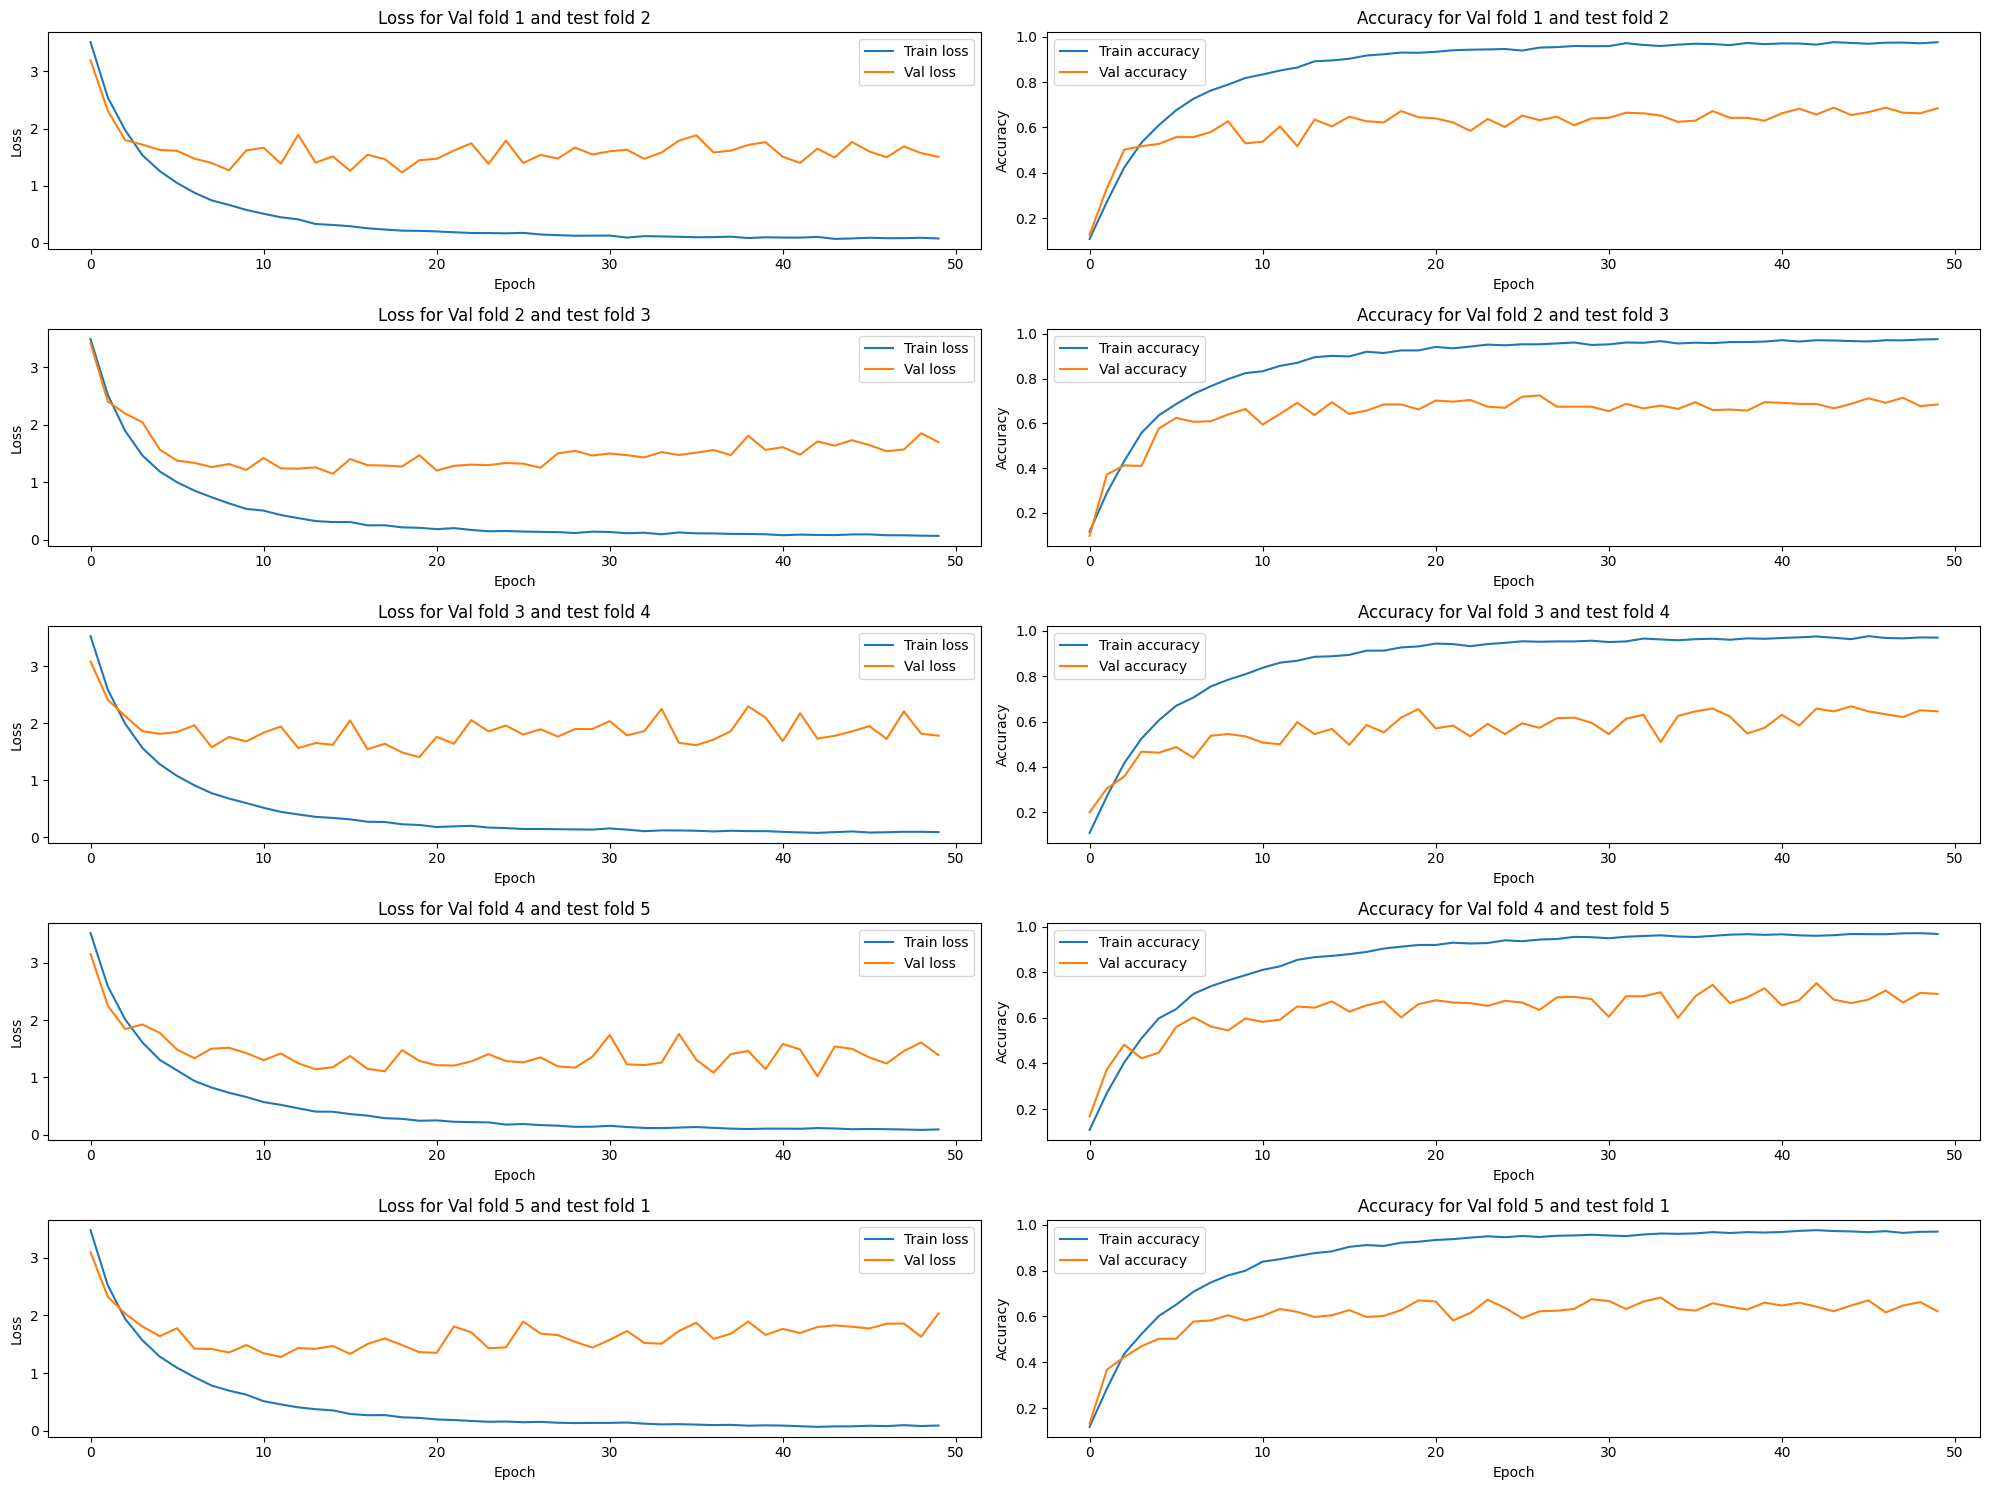

In [ ]:
#Training and evaluation on the augmented dataset obtained by pitch shifting
pitch_accuracy, pitch_time, y_test, pitch_preds = train_and_evaluate(MelNet, input_shape= (60, 216 ,2), type_input= "melspec")

In [ ]:
#Saving predictions
np.save("noise_preds.npy", noise_preds)
np.save("noaug_preds.npy", noaug_preds)
np.save("pitch_preds.npy", pitch_preds)
np.save("y_test.npy", y_test)

## Class-wise augmentation analysis

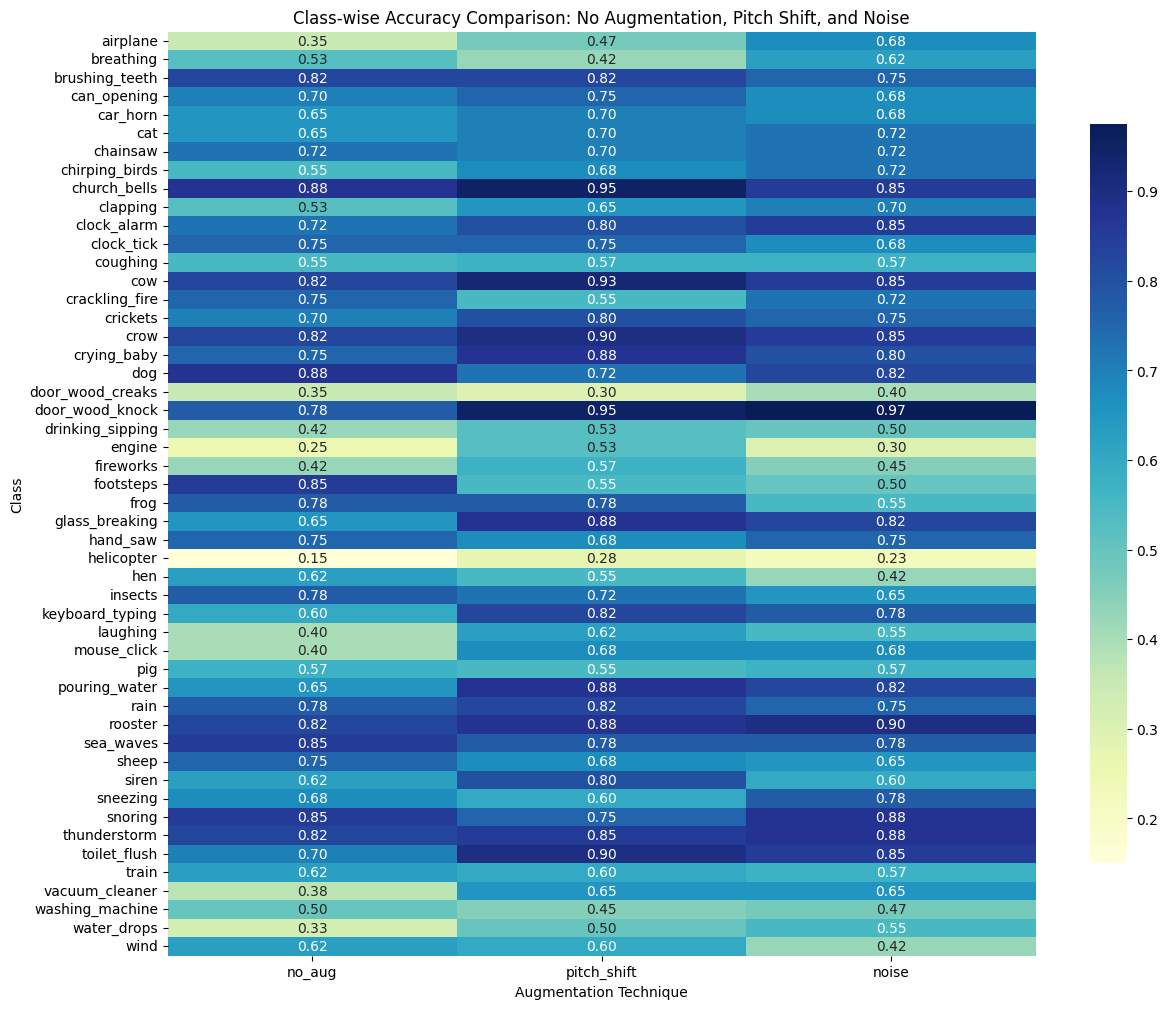

In [ ]:
# Load your data

pitch_shift_preds = np.load("/kaggle/input/comparison-aug/pitch_preds.npy")
noise_preds = np.load("/kaggle/input/noise-preds/noise_preds.npy")
no_aug_preds = np.load("/kaggle/input/comparison-aug/noaug_preds.npy")
true_labels_list = np.load("/kaggle/input/predictions/y_test.npy")

# Classes names
classes = label_encoder.classes_

# Construct a DataFrame which contains class-wise accuracies for each augmentation method
augment_methods = ['no_aug', 'pitch_shift', 'noise']
class_accuracy_df = pd.DataFrame(index=classes, columns=augment_methods)

#Convert probabilities to class labels
def convert_to_labels(predictions_list):
    processed_predictions_list = []
    for fold_preds in predictions_list:
        if fold_preds.ndim > 1:
            fold_preds = np.argmax(fold_preds, axis=1)
        processed_predictions_list.append(fold_preds)
    return processed_predictions_list



# Convert predictions to labels
no_aug_preds_labels = convert_to_labels(no_aug_preds)
pitch_shift_preds_labels = convert_to_labels(pitch_shift_preds)
noise_preds_labels = convert_to_labels(noise_preds)


# Calculate class-wise accuracy for each augmentation method
for aug, predictions_list in zip(augment_methods, [no_aug_preds_labels, pitch_shift_preds_labels, noise_preds_labels]):
    for cls_name in classes:
        # Get the numerical label for the class
        cls_label = label_encoder.transform([cls_name])[0]
        accuracies_per_fold = []
        # Loop over each fold
        for fold_idx in range(len(true_labels_list)):
            # Get predictions and true labels for the current fold
            true_labels_fold = true_labels_list[fold_idx]
            predictions_fold = predictions_list[fold_idx]

            # Filter indices for the current class
            cls_indices = np.where(true_labels_fold == cls_label)[0]
            cls_true = true_labels_fold[cls_indices]
            cls_preds = predictions_fold[cls_indices]


            # Calculate accuracy for the currect class in this fold
            if len(cls_true) > 0:
                fold_accuracy = accuracy_score(cls_true, cls_preds)
                accuracies_per_fold.append(fold_accuracy)

        # Average accuracy across folds for this class and augmentation method
        if accuracies_per_fold:
            class_accuracy_df.loc[cls_name, aug] = np.mean(accuracies_per_fold)
        else:
            class_accuracy_df.loc[cls_name, aug] = np.nan


# Plot the class-wise accuracy heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(class_accuracy_df.astype(float), annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title("Class-wise Accuracy Comparison: No Augmentation, Pitch Shift, and Noise")
plt.xlabel("Augmentation Technique")
plt.ylabel("Class")
plt.show()


## Log-Mel Net with mixup augmentation

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 1.4814, Accuracy: 0.6942, Val Loss: 1.3180, Val Accuracy: 0.6475
Epoch 20 - Loss: 1.0128, Accuracy: 0.8747, Val Loss: 1.1480, Val Accuracy: 0.6850
Epoch 30 - Loss: 0.8683, Accuracy: 0.9231, Val Loss: 1.1736, Val Accuracy: 0.7075
Epoch 40 - Loss: 0.8278, Accuracy: 0.9333, Val Loss: 1.1464, Val Accuracy: 0.7025
Epoch 50 - Loss: 0.7925, Accuracy: 0.9405, Val Loss: 1.0973, Val Accuracy: 0.6975
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step 
Fold 2 - Test Accuracy: 0.7074999809265137
Processing Fold 2 - Validation Fold: 2, Test Fold: 3
Epoch 10 - Loss: 1.4229, Accuracy: 0.7219, Val Loss: 1.4451, Val Accuracy: 0.5550
Epoch 20 - Loss: 0.9604, Accuracy: 0.8837, Val Loss: 1.1687, Val Accuracy: 0.6825
Epoch 30 - Loss: 0.8636, Accuracy: 0.9256, Val Loss: 1.0777, Val Accuracy: 0.7200
Epoch 40 - Loss: 0.8132, Accuracy: 0.9384, Val Loss: 1.0966, Val Accuracy: 0.7275
Epoch 50 - Loss: 0.7896, Accuracy: 0.9424, Val Loss: 1.2140, Val Accurac

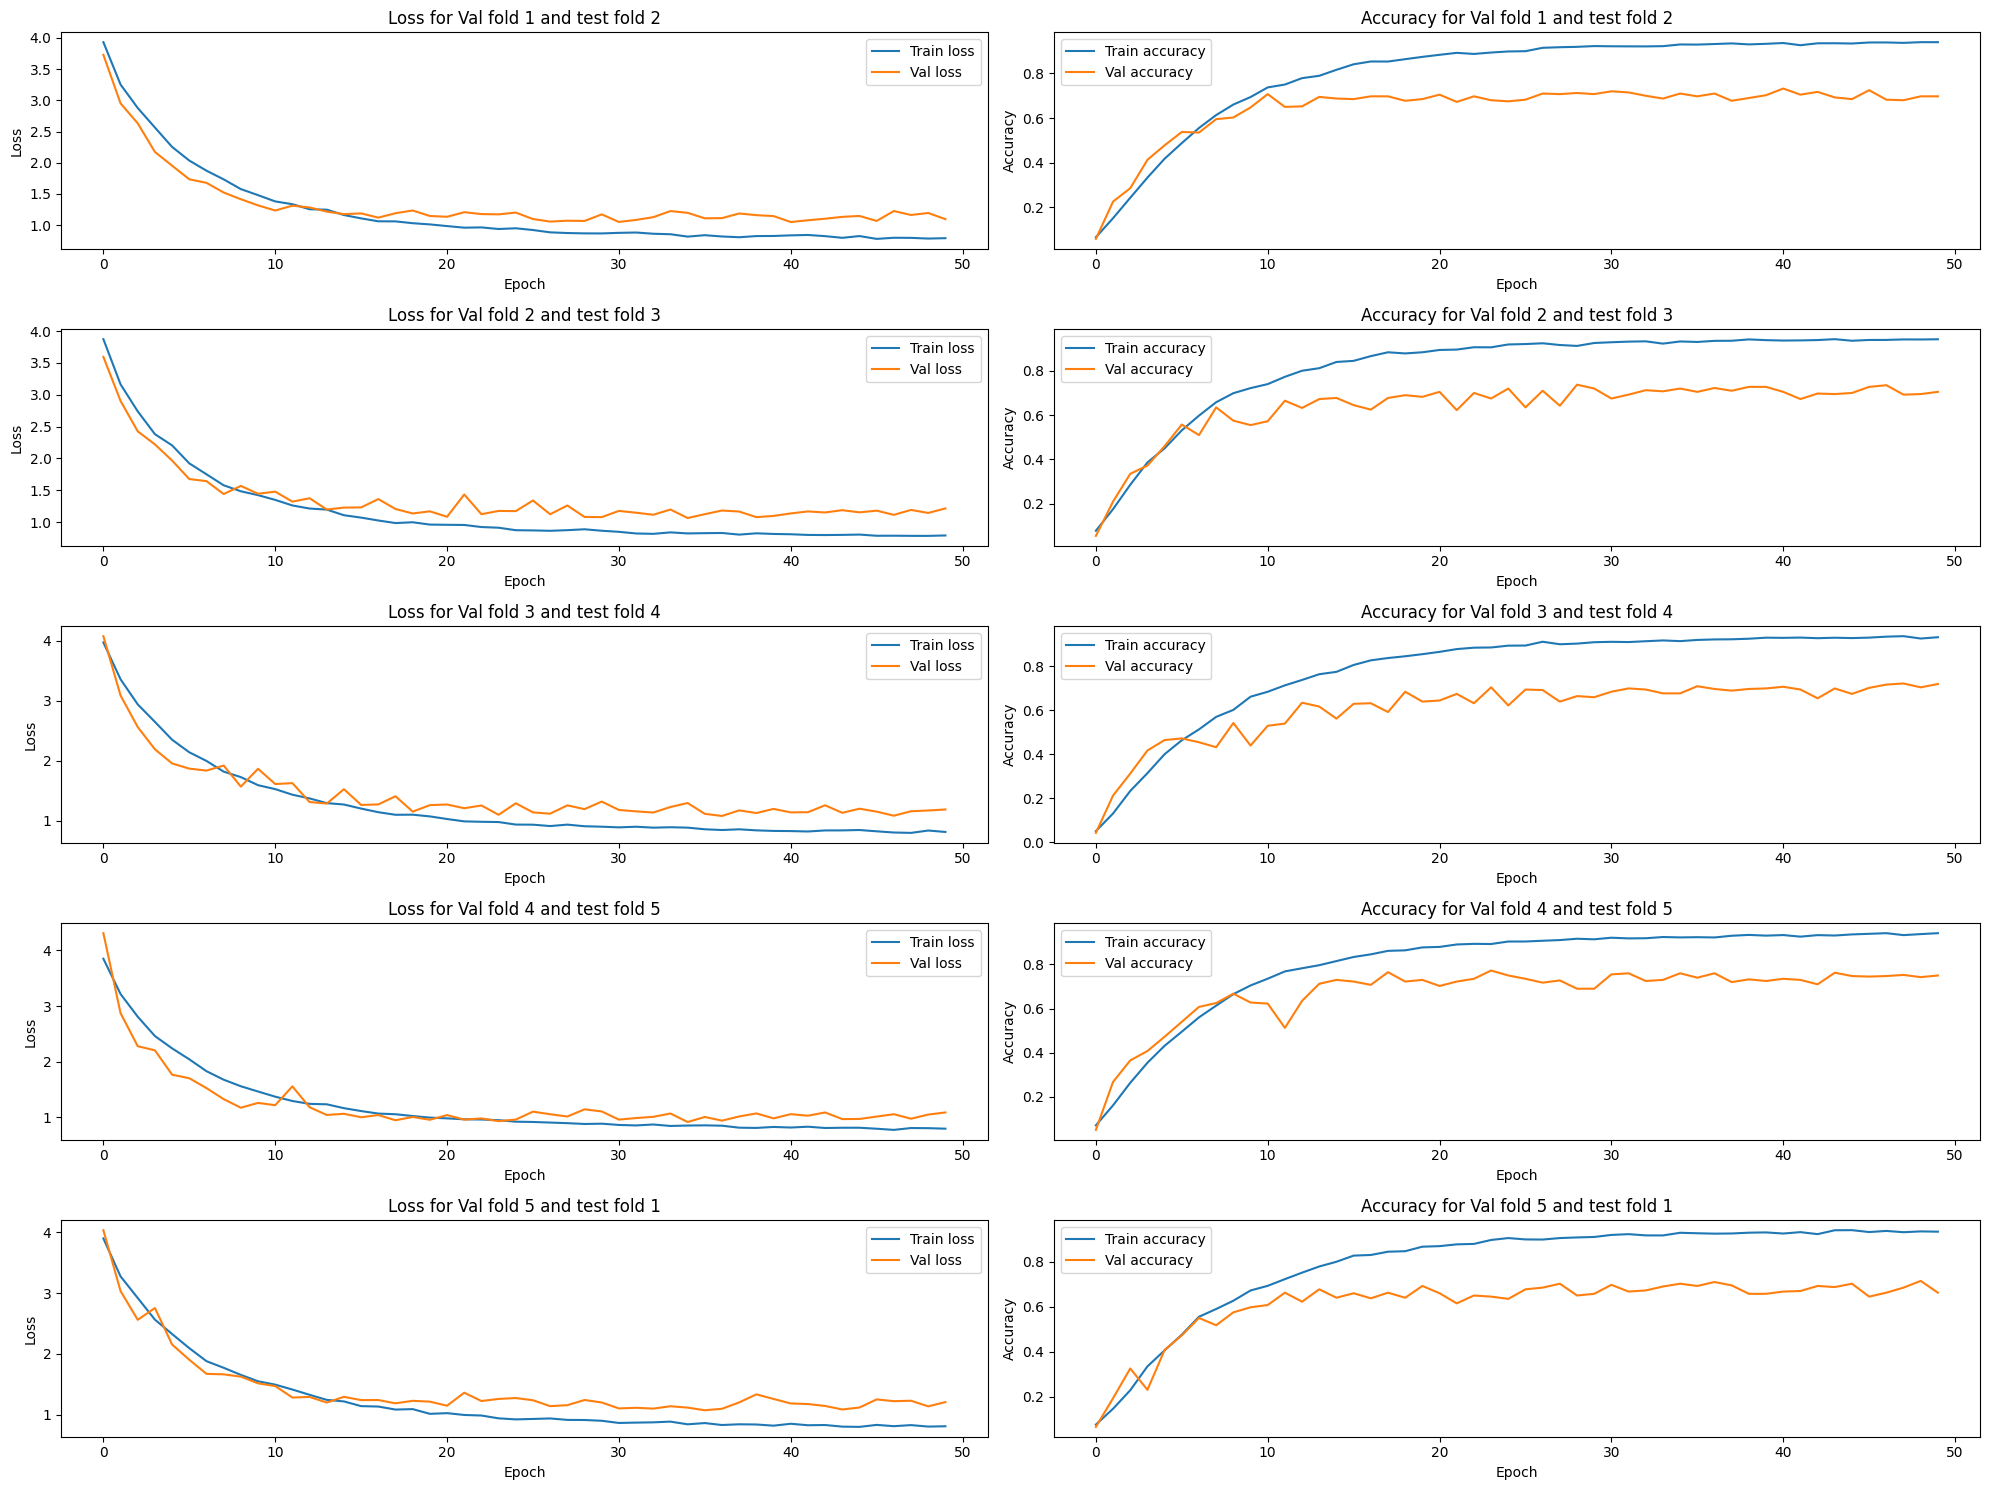

In [ ]:
accuracy_mix, time_mix, y_test, preds_mix = train_and_evaluate(MelNet, input_shape= (60, 216 ,2), type_input= "melspec", mixup = True)

Processing Fold 1 - Validation Fold: 1, Test Fold: 2


I0000 00:00:1731021536.224772     178 service.cc:145] XLA service 0x7fe3b40020c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731021536.224867     178 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731021549.196877     178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 10 - Loss: 1.6946, Accuracy: 0.6160, Val Loss: 1.3144, Val Accuracy: 0.6325
Epoch 20 - Loss: 1.2505, Accuracy: 0.7880, Val Loss: 1.1790, Val Accuracy: 0.6625
Epoch 30 - Loss: 1.0767, Accuracy: 0.8522, Val Loss: 1.1369, Val Accuracy: 0.6975
Epoch 40 - Loss: 0.9771, Accuracy: 0.8874, Val Loss: 1.3092, Val Accuracy: 0.6650
Epoch 50 - Loss: 0.9350, Accuracy: 0.9052, Val Loss: 1.3116, Val Accuracy: 0.6700
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Fold 2 - Test Accuracy: 0.6524999737739563
Processing Fold 2 - Validation Fold: 2, Test Fold: 3
Epoch 10 - Loss: 1.6509, Accuracy: 0.6363, Val Loss: 1.4052, Val Accuracy: 0.6275
Epoch 20 - Loss: 1.2134, Accuracy: 0.8020, Val Loss: 1.1042, Val Accuracy: 0.6575
Epoch 30 - Loss: 1.0246, Accuracy: 0.8739, Val Loss: 1.2127, Val Accuracy: 0.6625
Epoch 40 - Loss: 0.9702, Accuracy: 0.8940, Val Loss: 1.2461, Val Accuracy: 0.6900
Epoch 50 - Loss: 0.8956, Accuracy: 0.9166, Val Loss: 1.1897, Val Accuracy: 0.7075
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Fold

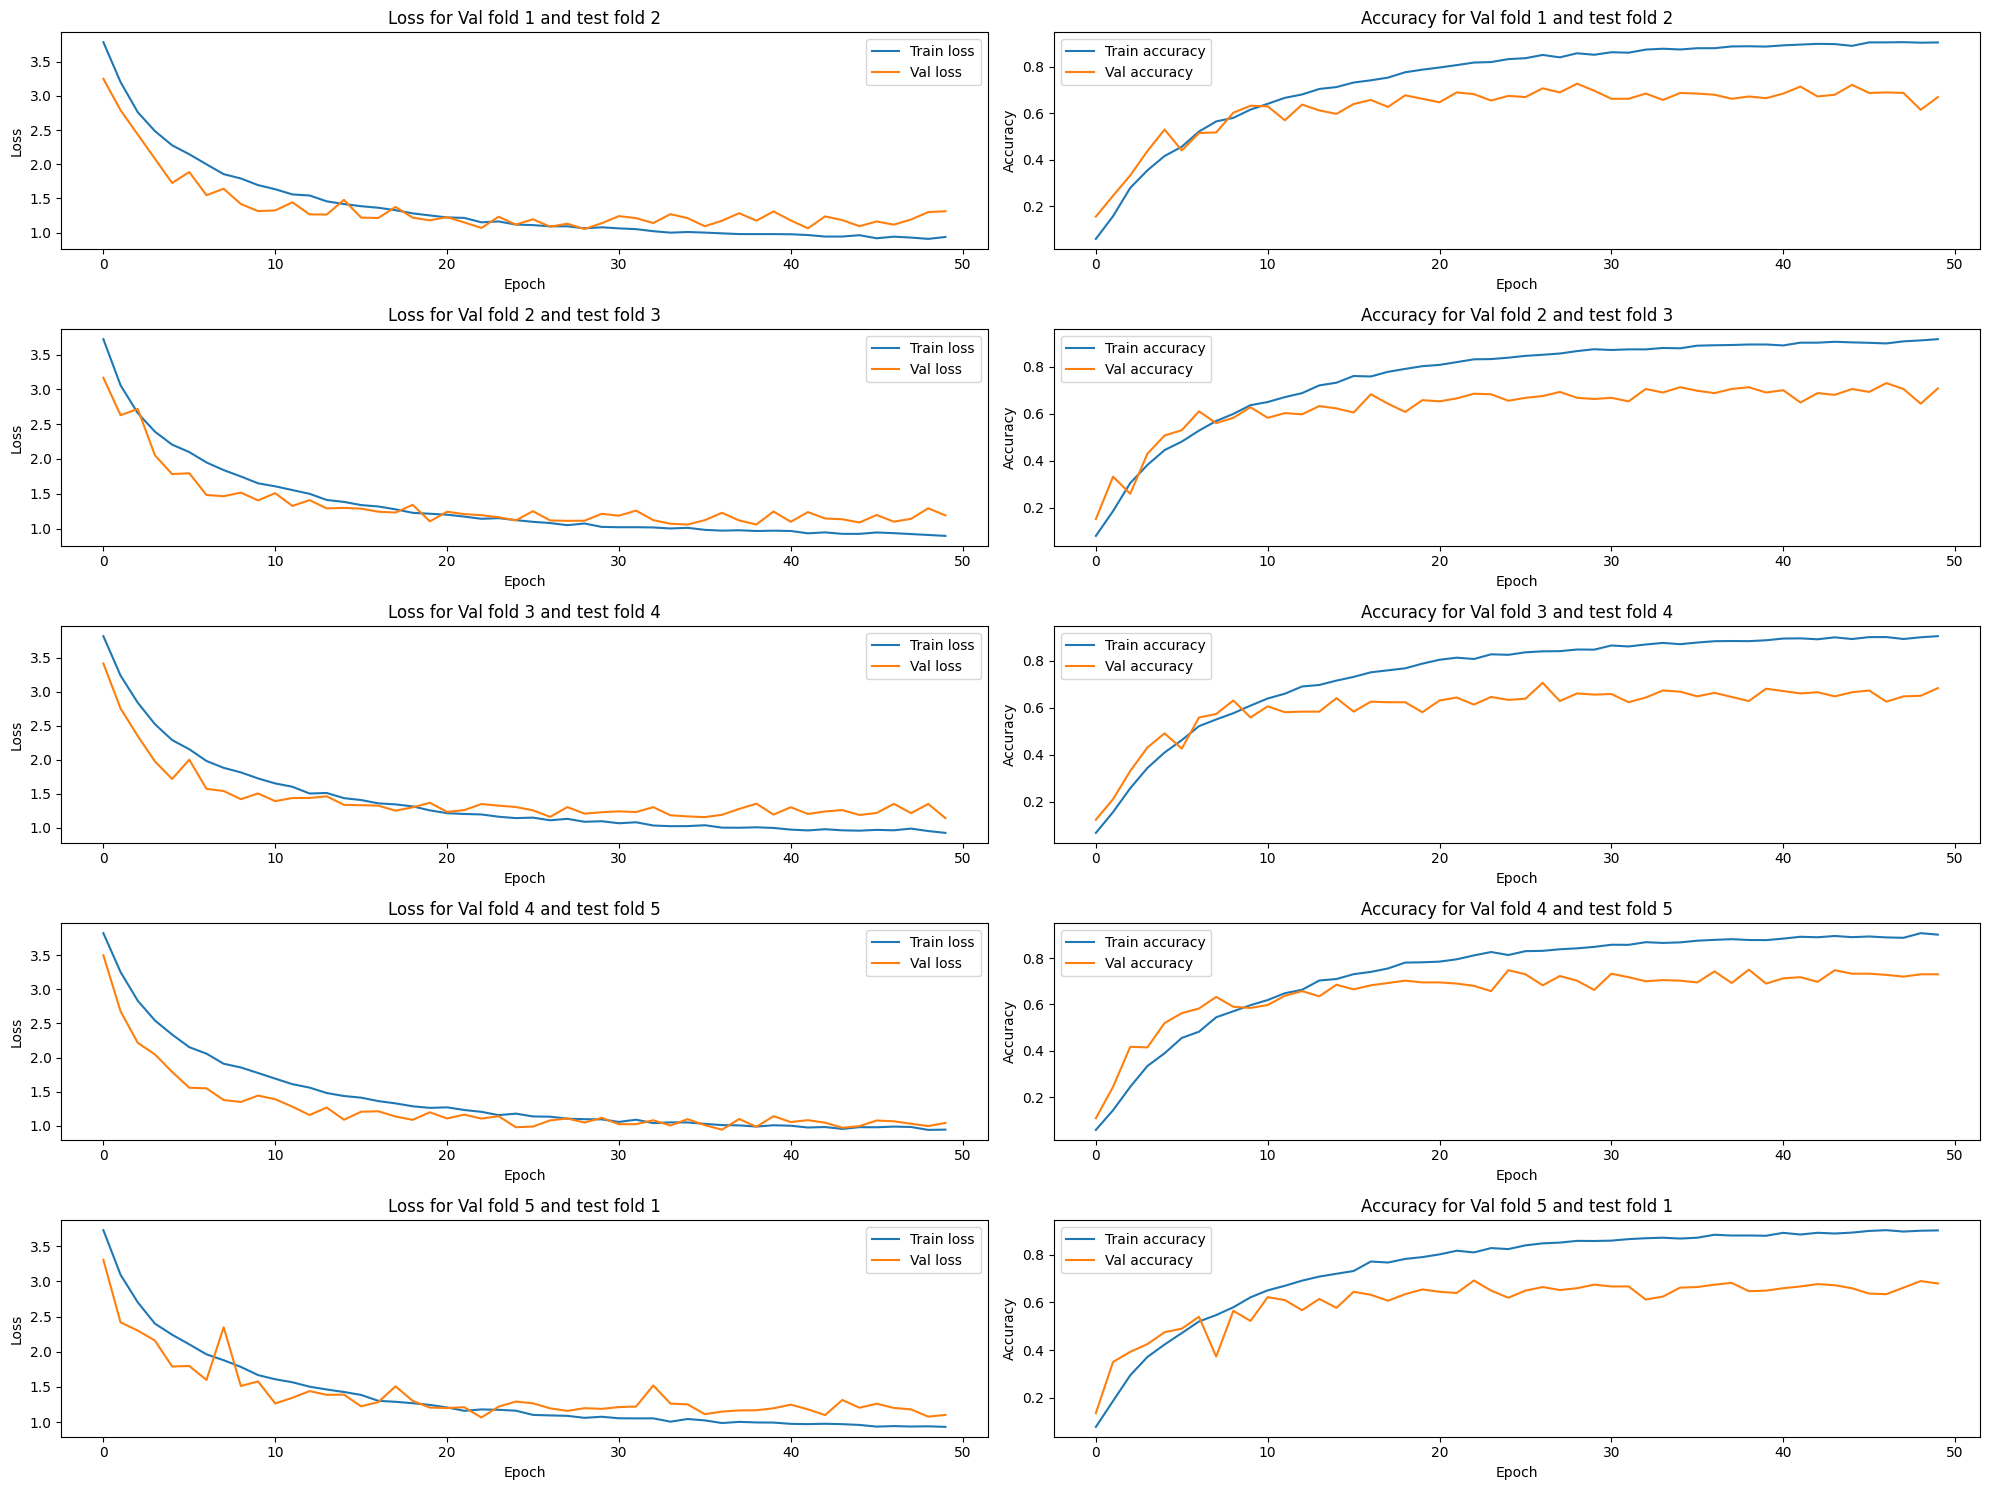

In [ ]:
#Mixup learning applied to the noise + pitch-shifted dataset
accuracy_all, time_all, y_test, preds_all = train_and_evaluate(MelNet, input_shape= (60, 216 ,2), type_input= "melspec", mixup = True)

In [ ]:
#Saving predictions
np.save("preds_mix.npy", preds_mix)
np.save("preds_all.npy", preds_all)

## MFCCNet

In [ ]:
def mfcc_Net(input_shape, variant):
    #Input layer
    X_input = tf.keras.Input(input_shape)

    # First Convolutional Block
    X = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer= regularizers.l2(0.001))(X_input)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.MaxPooling2D(2, padding='same')(X)

    # Second Convolutional Block
    X = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer= regularizers.l2(0.001))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.MaxPooling2D(2, padding='same')(X)
    X = tf.keras.layers.Dropout(0.3)(X)

    # Third Convolutional Block
    X = tf.keras.layers.Conv2D(128, (3,3), padding='same',kernel_regularizer= regularizers.l2(0.001))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.MaxPooling2D(2, padding='same')(X)
    X = tf.keras.layers.Dropout(0.3)(X)

    #Fourth Convolutional Block
    X = tf.keras.layers.Conv2D(256, (3,3), padding='same',kernel_regularizer= regularizers.l2(0.001))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation("relu")(X)
    X = tf.keras.layers.MaxPooling2D(2, padding='same')(X)
    X = tf.keras.layers.Dropout(0.3)(X)

    X = tf.keras.layers.GlobalMaxPooling2D()(X)


    X = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer= regularizers.l2(0.001))(X)
    X = tf.keras.layers.Dropout(0.5)(X)


    # Output layer
    if variant == 'ESC-10':
        X_output = tf.keras.layers.Dense(10, activation='softmax')(X)
    else:
        X_output = tf.keras.layers.Dense(50, activation='softmax')(X)


    # Define the model
    model = tf.keras.Model(inputs=X_input, outputs=X_output, name="mfcc_Net")
    return model

mfcc_net = mfcc_Net((21,216,3), 'ESC-50')
mfcc_net.summary()

Model: "mfcc_Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 216, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 216, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 216, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 21, 216, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 54, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 54, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 54, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 54, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 6, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 27, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 27, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 468,978 (1.79 MB)

 Trainable params: 468,018 (1.79 MB)

 Non-trainable params: 960 (3.75 KB)

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 3.6026, Accuracy: 0.1408, Val Loss: 3.7683, Val Accuracy: 0.1700
Epoch 20 - Loss: 2.5925, Accuracy: 0.3383, Val Loss: 2.9467, Val Accuracy: 0.3200
Epoch 30 - Loss: 2.0041, Accuracy: 0.5158, Val Loss: 2.4642, Val Accuracy: 0.4400
Epoch 40 - Loss: 1.6028, Accuracy: 0.6317, Val Loss: 2.6906, Val Accuracy: 0.3850
Epoch 50 - Loss: 1.4188, Accuracy: 0.6892, Val Loss: 2.3947, Val Accuracy: 0.4825
Epoch 60 - Loss: 1.1869, Accuracy: 0.7642, Val Loss: 2.1507, Val Accuracy: 0.5250
Epoch 70 - Loss: 1.0789, Accuracy: 0.7958, Val Loss: 2.2089, Val Accuracy: 0.4750
Epoch 80 - Loss: 0.9480, Accuracy: 0.8467, Val Loss: 2.1291, Val Accuracy: 0.5600
Epoch 90 - Loss: 0.9017, Accuracy: 0.8542, Val Loss: 2.0144, Val Accuracy: 0.5875
Epoch 100 - Loss: 0.9121, Accuracy: 0.8617, Val Loss: 2.4383, Val Accuracy: 0.5450
Epoch 110 - Loss: 0.8193, Accuracy: 0.8900, Val Loss: 2.3777, Val Accuracy: 0.5200
Epoch 120 - Loss: 0.7920, Accuracy: 0.8942,

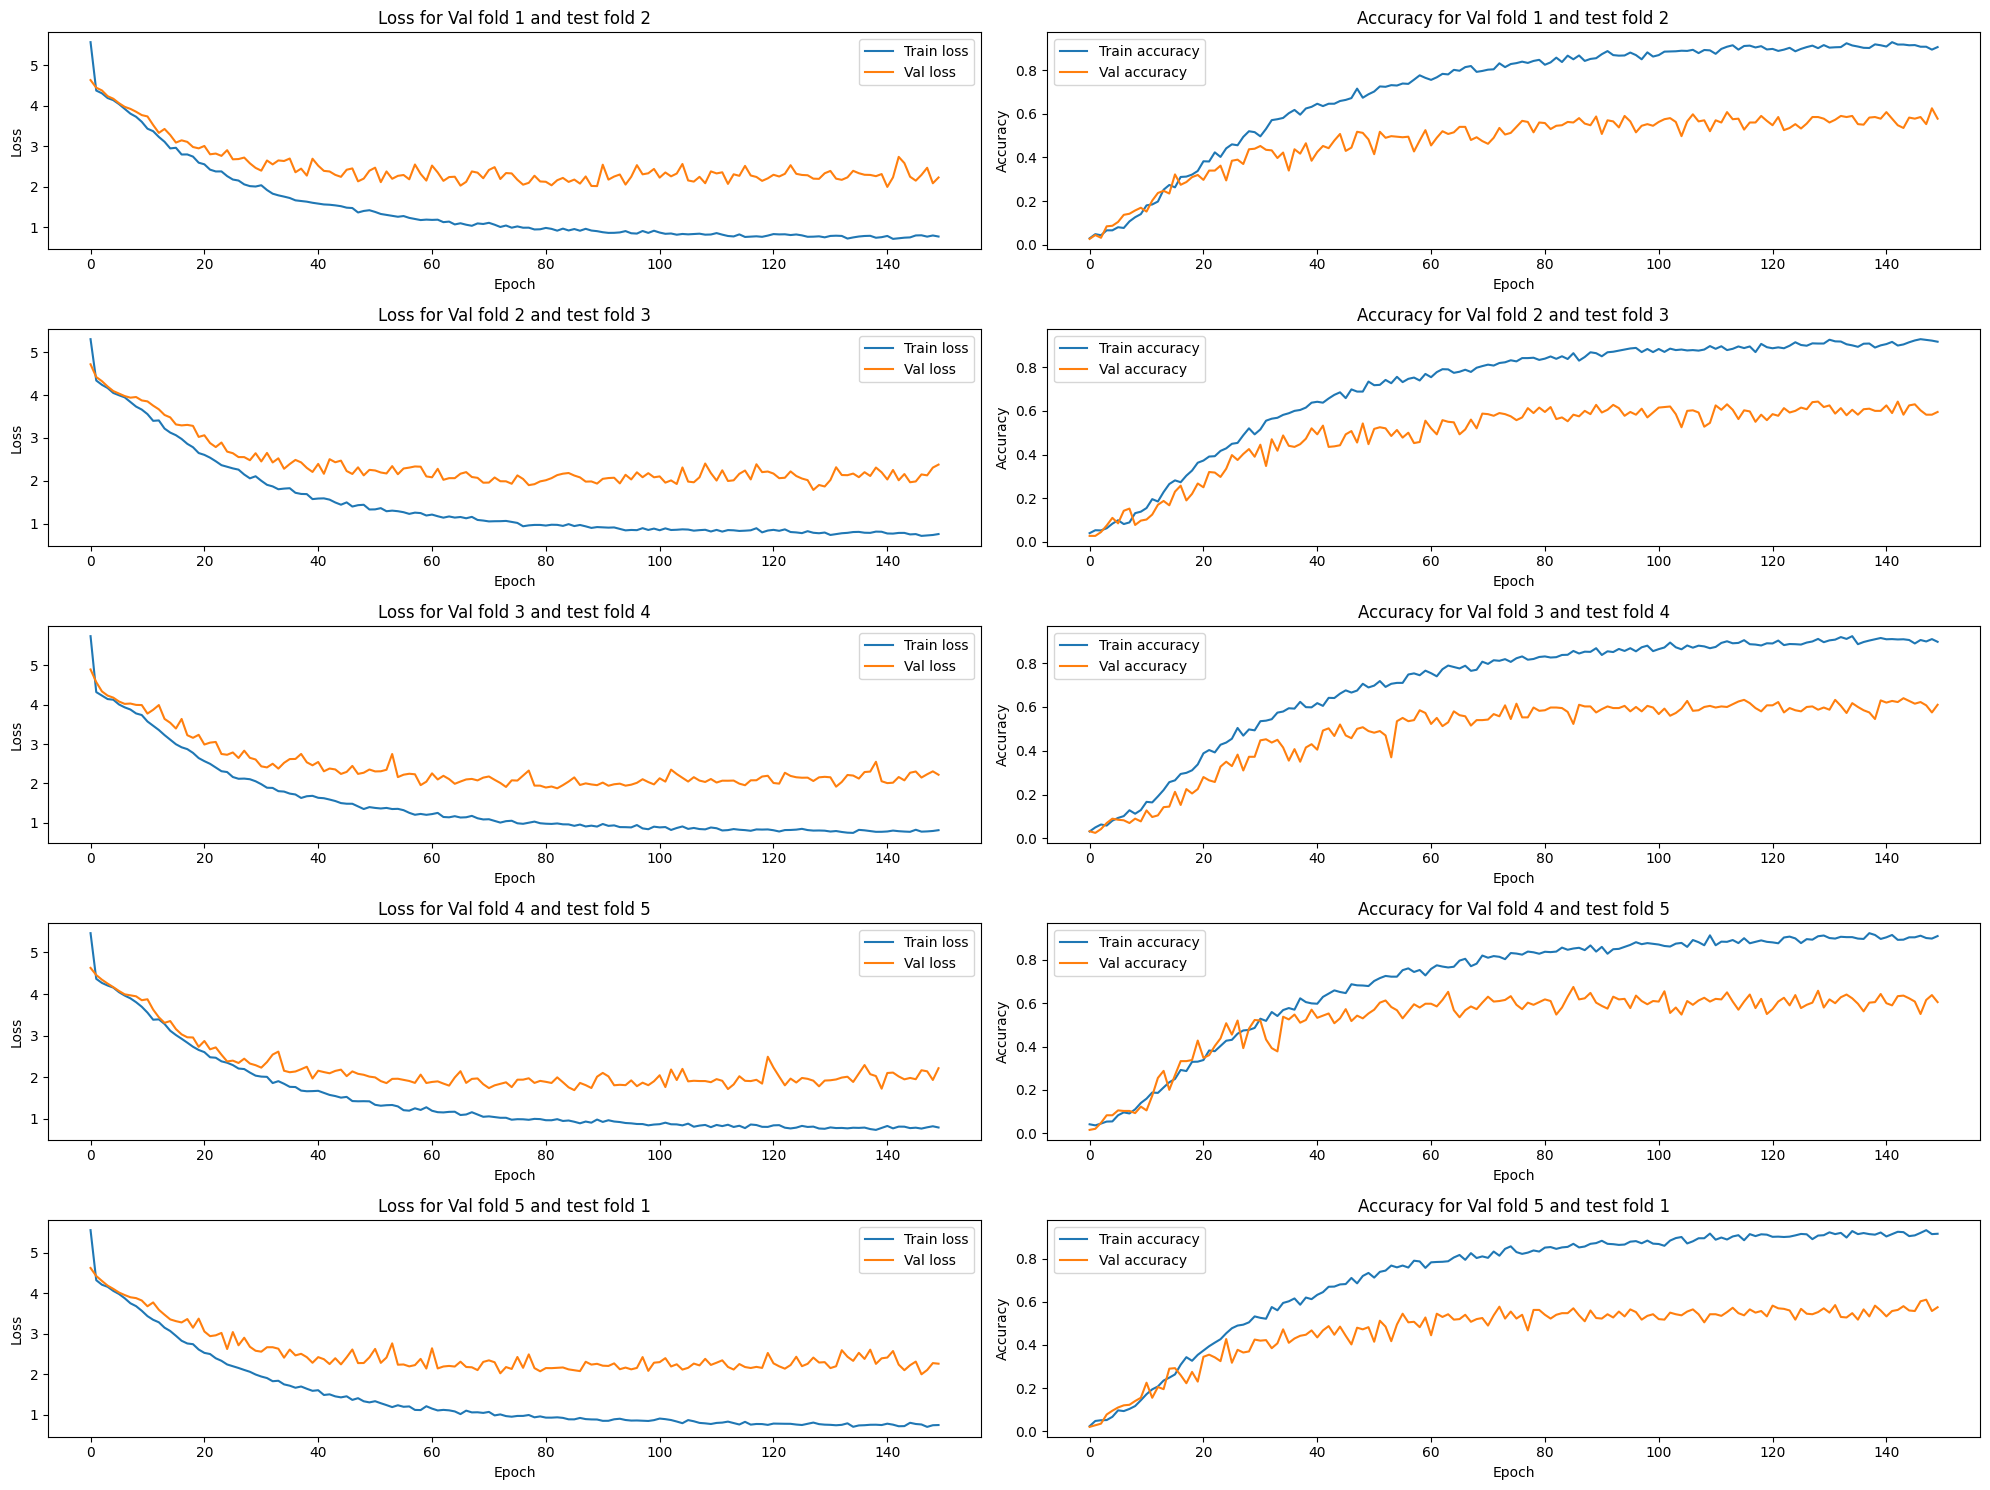

In [ ]:
#Training and evaluation of MFCCNet on the standard dataset
mfcc_accuracy_noaug, mfcc_time_noaug, y_test, mfccnet_preds_noaug = train_and_evaluate(mfcc_Net, input_shape= (21,216,3), type_input= "mfcc")

Processing Fold 1 - Validation Fold: 1, Test Fold: 2


I0000 00:00:1731513538.387227      91 service.cc:145] XLA service 0x5a061507ac30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731513538.387290      91 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731513546.134162      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 10 - Loss: 1.8008, Accuracy: 0.5710, Val Loss: 2.2278, Val Accuracy: 0.4600
Epoch 20 - Loss: 1.1989, Accuracy: 0.7687, Val Loss: 2.0813, Val Accuracy: 0.5575
Epoch 30 - Loss: 0.9942, Accuracy: 0.8468, Val Loss: 2.4139, Val Accuracy: 0.5450
Epoch 40 - Loss: 0.9316, Accuracy: 0.8778, Val Loss: 2.7781, Val Accuracy: 0.4800
Epoch 50 - Loss: 0.9071, Accuracy: 0.8865, Val Loss: 2.3930, Val Accuracy: 0.5600
Epoch 60 - Loss: 0.8754, Accuracy: 0.9037, Val Loss: 2.5109, Val Accuracy: 0.5625
Epoch 70 - Loss: 0.8772, Accuracy: 0.9040, Val Loss: 2.3081, Val Accuracy: 0.5800
Epoch 80 - Loss: 0.8336, Accuracy: 0.9218, Val Loss: 2.4835, Val Accuracy: 0.5750
Epoch 90 - Loss: 0.8451, Accuracy: 0.9160, Val Loss: 2.8869, Val Accuracy: 0.5225
Epoch 100 - Loss: 0.8442, Accuracy: 0.9215, Val Loss: 3.0152, Val Accuracy: 0.5250
Epoch 110 - Loss: 0.8058, Accuracy: 0.9312, Val Loss: 2.7250, Val Accuracy: 0.5925
Epoch 120 - Loss: 0.7826, Accuracy: 0.9368, Val Loss: 2.8417, Val Accuracy: 0.5725
Epoch 130 - L

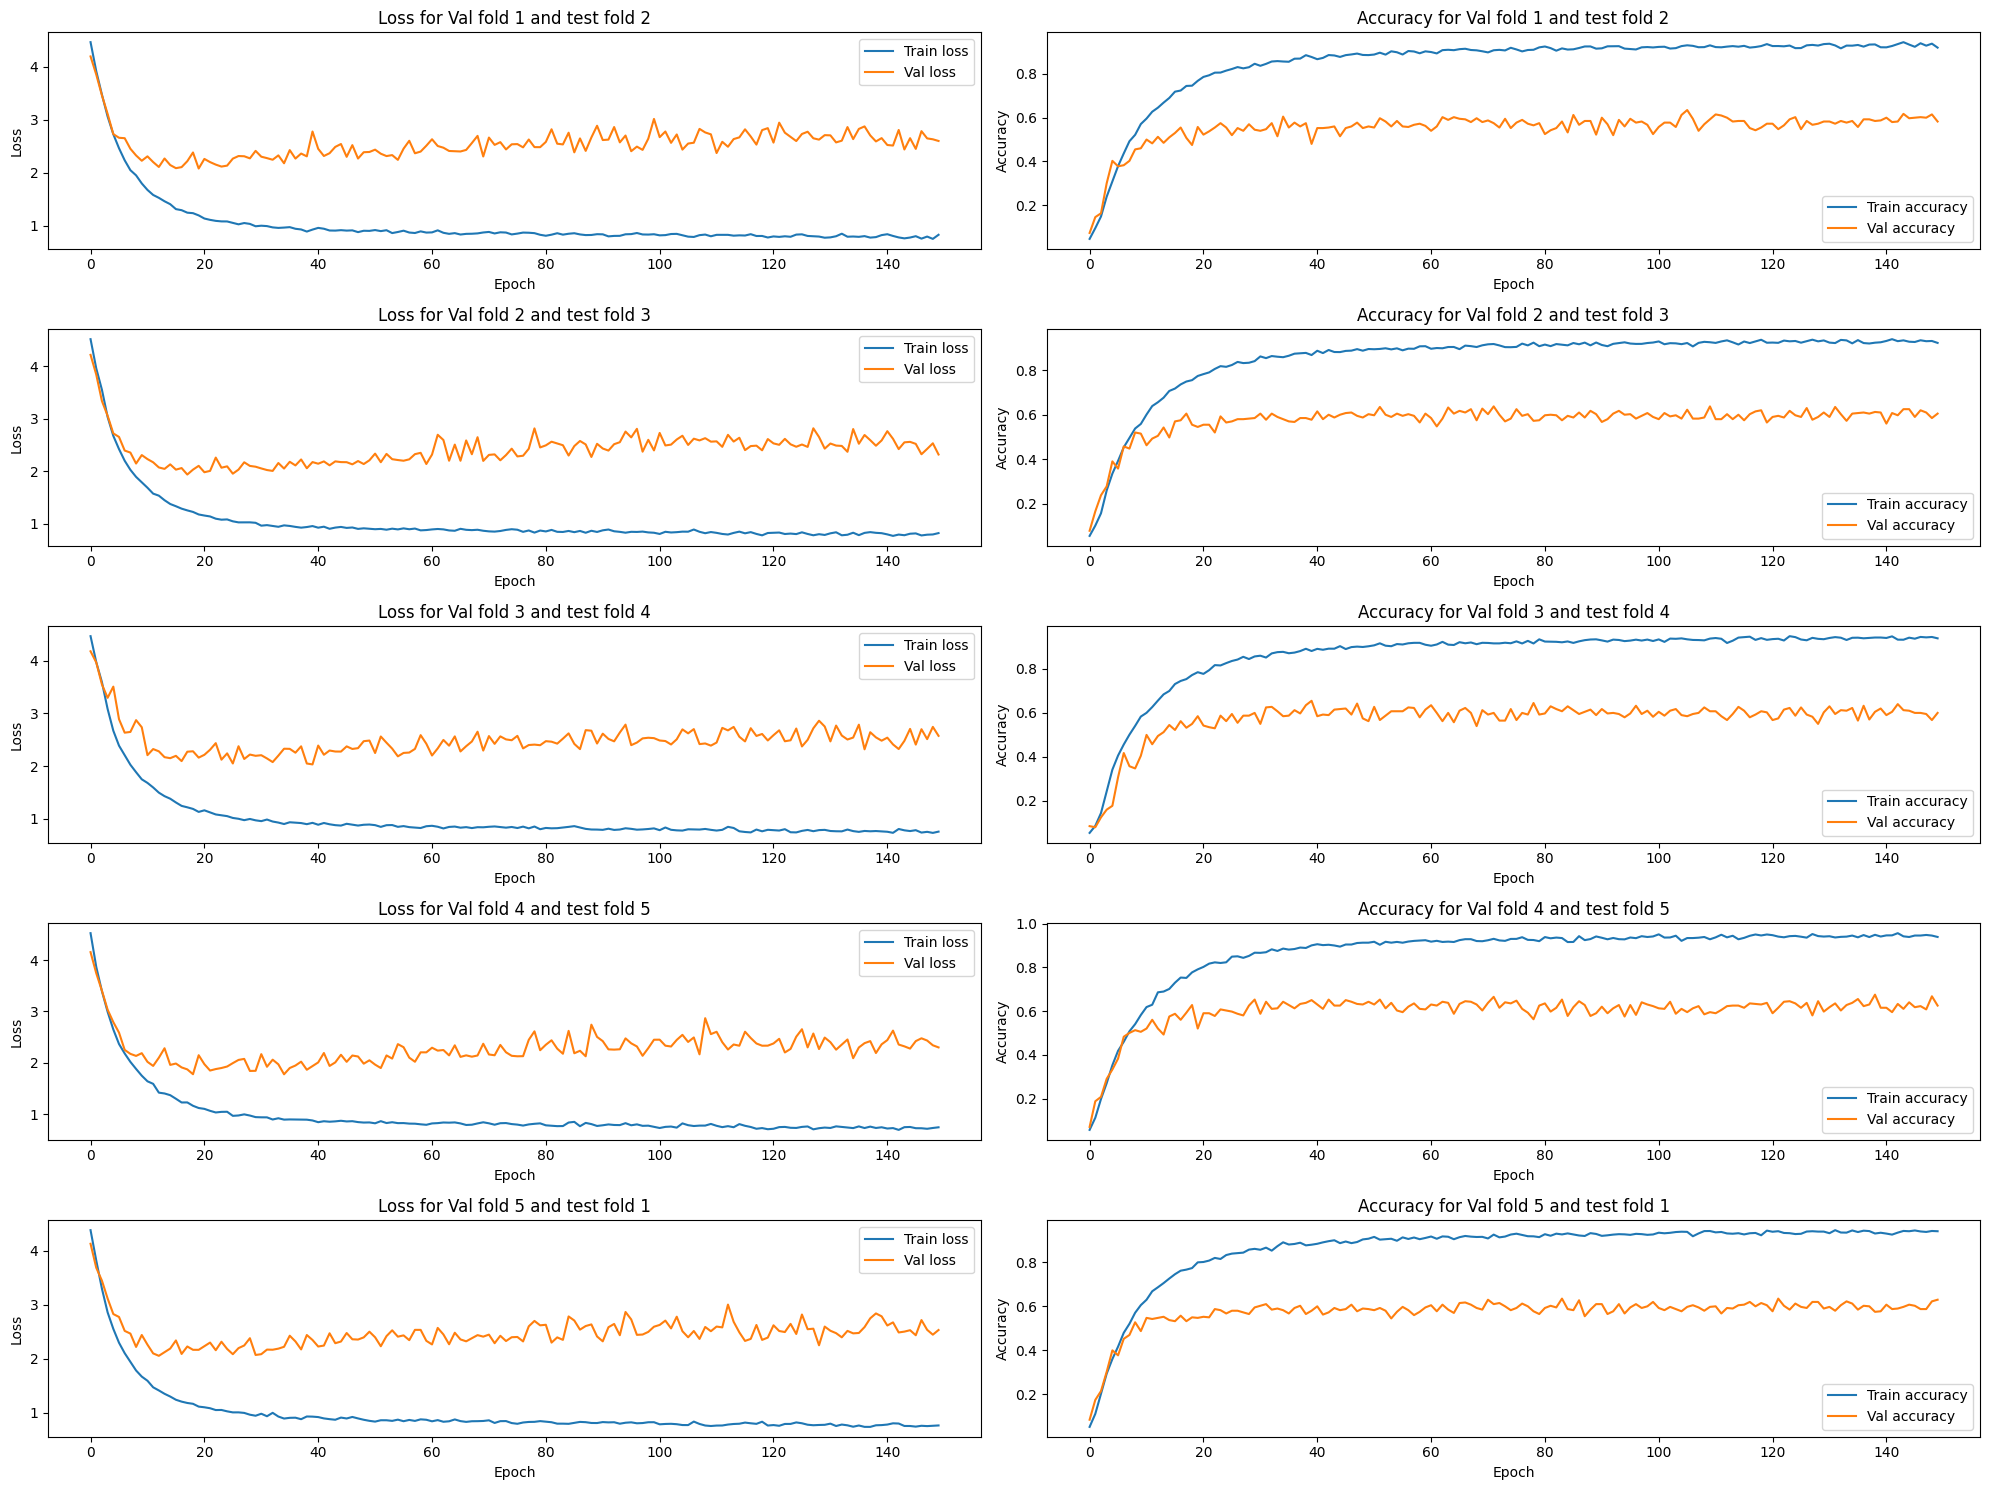

In [ ]:
#Training and evaluation of MFCCNet on the noisy dataset
mfcc_accuracy_noise, mfcc_time_noise, y_test, mfccnet_preds_noise = train_and_evaluate(mfcc_Net, input_shape= (21,216,3), type_input= "mfcc")

Processing Fold 1 - Validation Fold: 1, Test Fold: 2


I0000 00:00:1731424079.388319     104 service.cc:145] XLA service 0x7bd44c035630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731424079.388383     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731424087.808988     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 10 - Loss: 1.8805, Accuracy: 0.5455, Val Loss: 2.2490, Val Accuracy: 0.4750
Epoch 20 - Loss: 1.3105, Accuracy: 0.7295, Val Loss: 2.0885, Val Accuracy: 0.5550
Epoch 30 - Loss: 1.1297, Accuracy: 0.7978, Val Loss: 2.0436, Val Accuracy: 0.5775
Epoch 40 - Loss: 1.0330, Accuracy: 0.8452, Val Loss: 2.1442, Val Accuracy: 0.5625
Epoch 50 - Loss: 0.9956, Accuracy: 0.8685, Val Loss: 2.2177, Val Accuracy: 0.5625
Epoch 60 - Loss: 1.0034, Accuracy: 0.8697, Val Loss: 2.2272, Val Accuracy: 0.5525
Epoch 70 - Loss: 0.9495, Accuracy: 0.8895, Val Loss: 2.1127, Val Accuracy: 0.6100
Epoch 80 - Loss: 0.9011, Accuracy: 0.9008, Val Loss: 2.2550, Val Accuracy: 0.5750
Epoch 90 - Loss: 0.9156, Accuracy: 0.9048, Val Loss: 2.4003, Val Accuracy: 0.6000
Epoch 100 - Loss: 0.9386, Accuracy: 0.8982, Val Loss: 2.3871, Val Accuracy: 0.5825
Epoch 110 - Loss: 0.8508, Accuracy: 0.9218, Val Loss: 2.3173, Val Accuracy: 0.5950
Epoch 120 - Loss: 0.8775, Accuracy: 0.9163, Val Loss: 2.2394, Val Accuracy: 0.6175
Epoch 130 - L

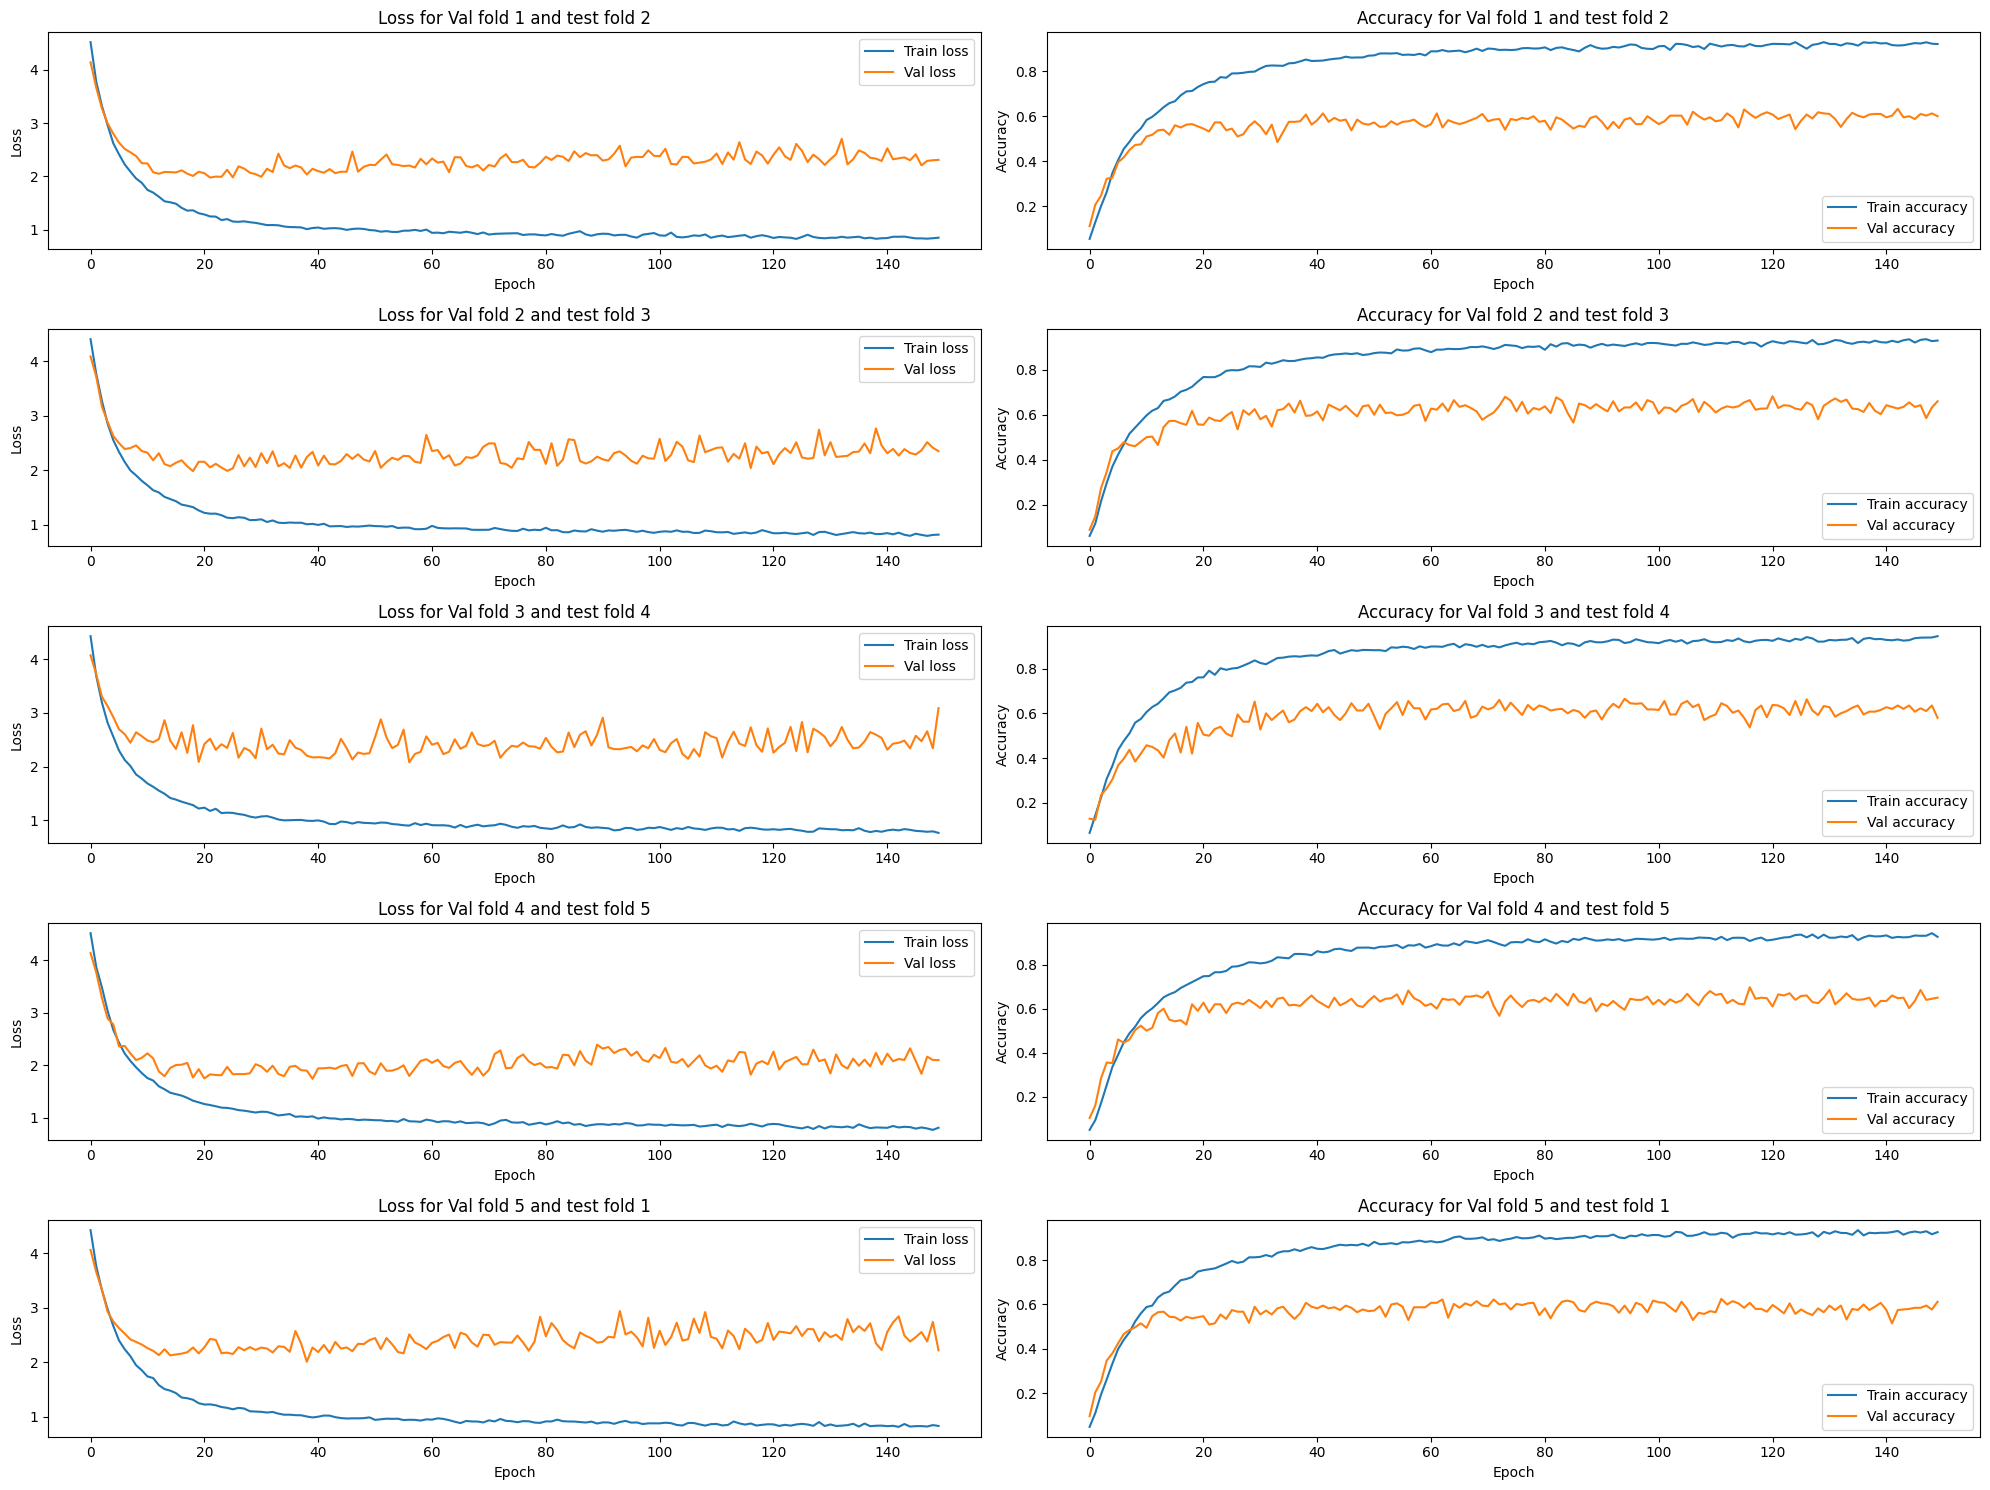

In [ ]:
#Training and evaluation of MFCCNet on the pitch shifted dataset
mfcc_accuracy_pitch, mfcc_time_pitch, y_test, mfccnet_preds_pitch = train_and_evaluate(mfcc_Net, input_shape= (21,216,3), type_input= "mfcc")

## MFCCNet with mixup augmentation

Processing Fold 1 - Validation Fold: 1, Test Fold: 2


I0000 00:00:1731026231.892815     108 service.cc:145] XLA service 0x7f3c40002050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731026231.892883     108 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731026240.879751     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 10 - Loss: 2.7006, Accuracy: 0.3888, Val Loss: 2.8900, Val Accuracy: 0.3575
Epoch 20 - Loss: 2.1116, Accuracy: 0.5977, Val Loss: 2.0330, Val Accuracy: 0.5800
Epoch 30 - Loss: 1.8477, Accuracy: 0.7136, Val Loss: 1.9090, Val Accuracy: 0.6150
Epoch 40 - Loss: 1.6785, Accuracy: 0.7784, Val Loss: 2.0421, Val Accuracy: 0.5400
Epoch 50 - Loss: 1.6063, Accuracy: 0.8097, Val Loss: 2.0643, Val Accuracy: 0.5225
Epoch 60 - Loss: 1.5361, Accuracy: 0.8335, Val Loss: 1.8427, Val Accuracy: 0.6225
Epoch 70 - Loss: 1.5055, Accuracy: 0.8455, Val Loss: 1.7085, Val Accuracy: 0.6575
Epoch 80 - Loss: 1.4793, Accuracy: 0.8634, Val Loss: 1.8135, Val Accuracy: 0.6325
Epoch 90 - Loss: 1.4530, Accuracy: 0.8601, Val Loss: 1.7913, Val Accuracy: 0.6450
Epoch 100 - Loss: 1.4506, Accuracy: 0.8623, Val Loss: 1.8079, Val Accuracy: 0.5975
Epoch 110 - Loss: 1.4118, Accuracy: 0.8647, Val Loss: 1.7168, Val Accuracy: 0.6375
Epoch 120 - Loss: 1.4286, Accuracy: 0.8685, Val Loss: 1.7392, Val Accuracy: 0.6325
Epoch 130 - L

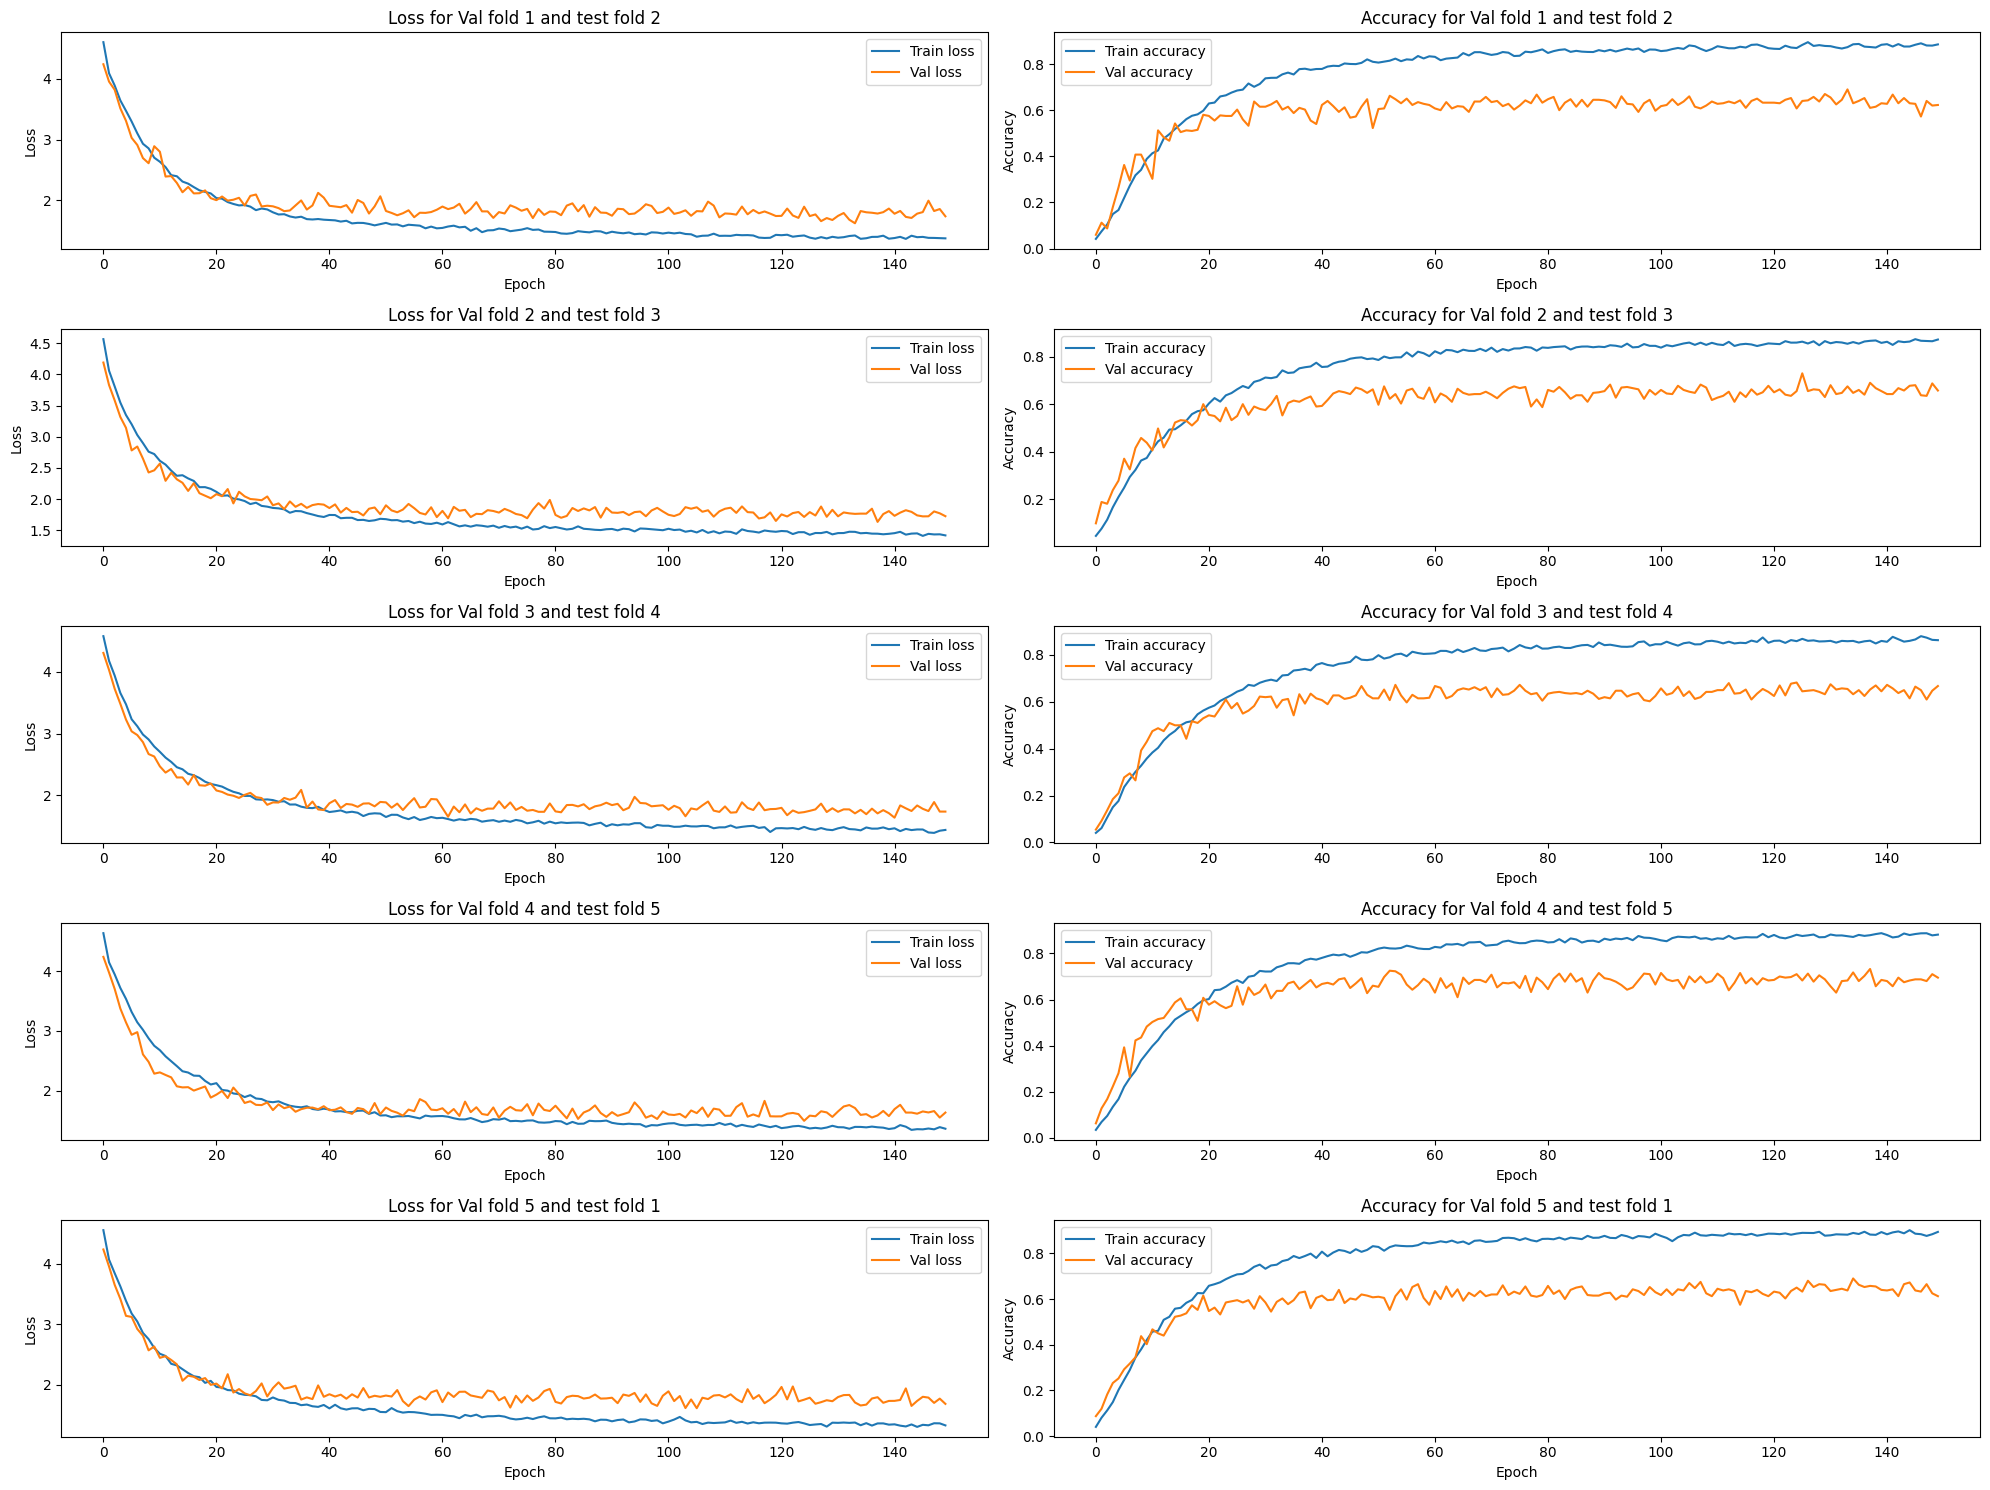

In [ ]:
mfcc_accuracy, mfcc_time, y_test, mfccnet_preds = train_and_evaluate(mfcc_Net, input_shape= (21,216,3), type_input= "mfcc", mixup=True)

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 2.9877, Accuracy: 0.2783, Val Loss: 2.6640, Val Accuracy: 0.4075
Epoch 20 - Loss: 2.5593, Accuracy: 0.4197, Val Loss: 2.3552, Val Accuracy: 0.4950
Epoch 30 - Loss: 2.3740, Accuracy: 0.5082, Val Loss: 2.1174, Val Accuracy: 0.5525
Epoch 40 - Loss: 2.2938, Accuracy: 0.5355, Val Loss: 1.9963, Val Accuracy: 0.5725
Epoch 50 - Loss: 2.2146, Accuracy: 0.5836, Val Loss: 2.0480, Val Accuracy: 0.5550
Epoch 60 - Loss: 2.1009, Accuracy: 0.6296, Val Loss: 1.9111, Val Accuracy: 0.5950
Epoch 70 - Loss: 2.0183, Accuracy: 0.6661, Val Loss: 1.9471, Val Accuracy: 0.5925
Epoch 80 - Loss: 2.0048, Accuracy: 0.6716, Val Loss: 1.9618, Val Accuracy: 0.6350
Epoch 90 - Loss: 1.9897, Accuracy: 0.6822, Val Loss: 1.8364, Val Accuracy: 0.6375
Epoch 100 - Loss: 1.9979, Accuracy: 0.6920, Val Loss: 1.9881, Val Accuracy: 0.6000
Epoch 110 - Loss: 1.9430, Accuracy: 0.7028, Val Loss: 1.8768, Val Accuracy: 0.6275
Epoch 120 - Loss: 1.9028, Accuracy: 0.7095,

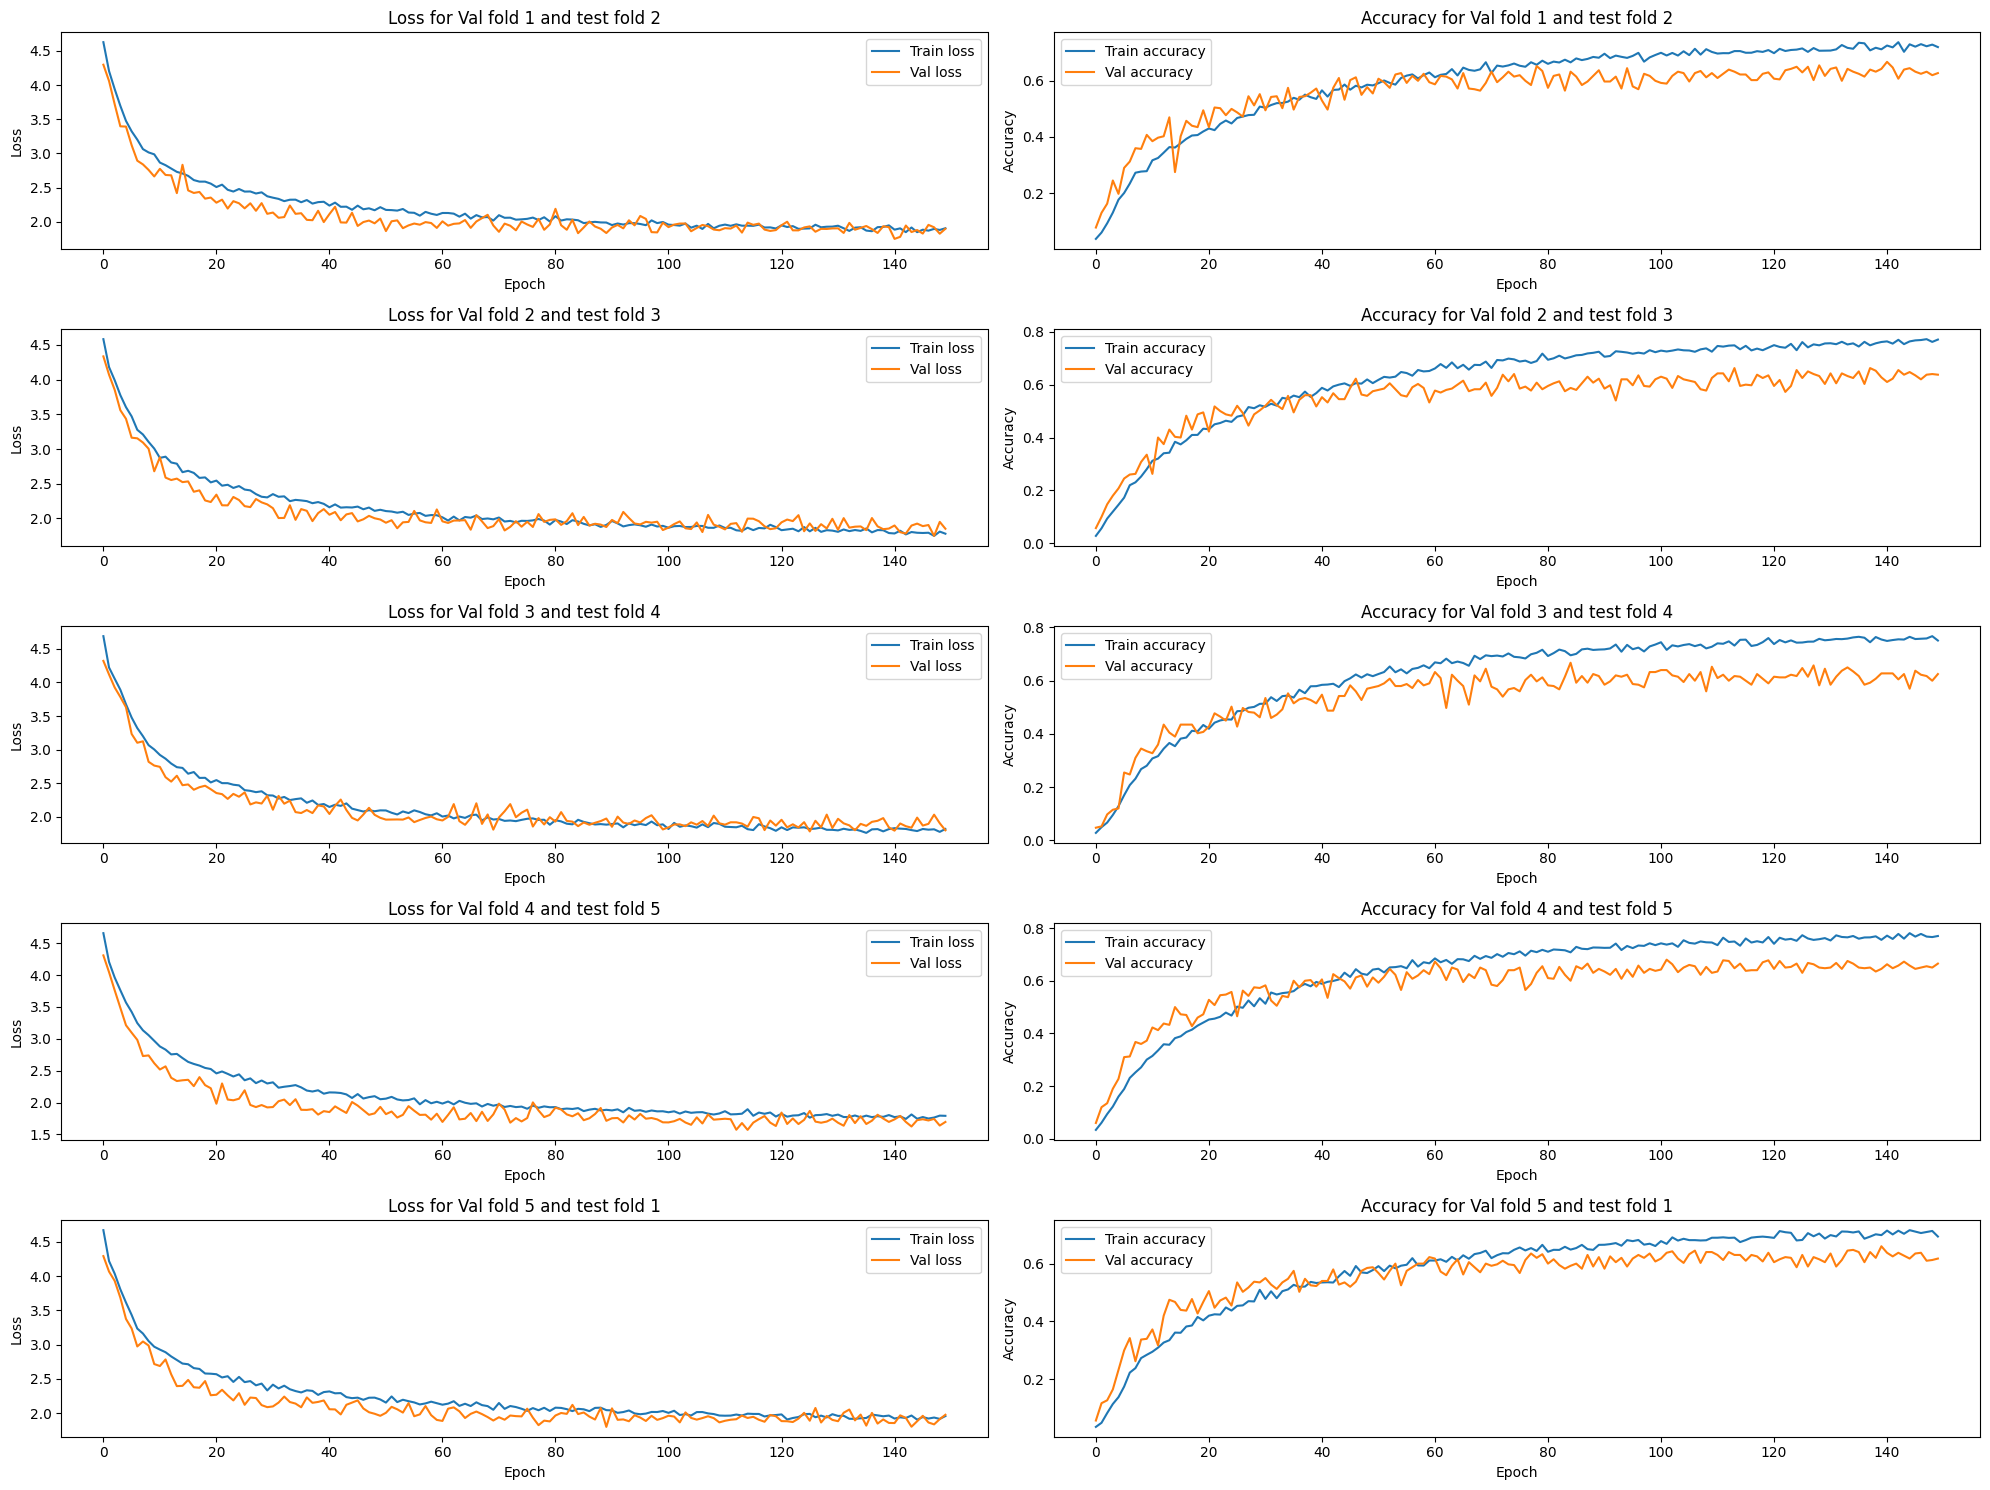

In [ ]:
mfcc_accuracy_all, mfcc_time_all, y_test, mfccnet_preds_all = train_and_evaluate(mfcc_Net, input_shape= (21,216,3), type_input= "mfcc", mixup=True)

## RawNet m11: very deep CNN on raw waveforms

In [ ]:
def m11(input_shape, variant):
    # Input layer
    X_input = tf.keras.Input(shape=input_shape)

    # First Convolutional Block
    X = tf.keras.layers.Conv1D(
        64,
        kernel_size=80,
        strides=4,
        padding='same',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(0.0001))(X_input)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(pool_size=4)(X)

    # Second Convolutional Block
    for _ in range(2):
        X = tf.keras.layers.Conv1D(
            64,
            kernel_size=3,
            strides=1,
            padding='same',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(0.0001))(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(pool_size=4)(X)

    # Third Convolutional Block
    for _ in range(2):
        X = tf.keras.layers.Conv1D(
            128,
            kernel_size=3,
            strides=1,
            padding='same',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(0.0001))(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(pool_size=4)(X)

    # Fourth Convolutional Block
    for _ in range(3):
        X = tf.keras.layers.Conv1D(
            256,
            kernel_size=3,
            strides=1,
            padding='same',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(0.0001))(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(pool_size=4)(X)

    # Fifth Convolutional Block
    for _ in range(2):
        X = tf.keras.layers.Conv1D(
            512,
            kernel_size=3,
            strides=1,
            padding='same',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(0.0001))(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)

    # Global Average Pooling
    X = tf.keras.layers.GlobalAveragePooling1D()(X)

    # Output layer
    if variant == 'ESC-10':
        X_output = tf.keras.layers.Dense(10, activation='softmax')(X)
    else:
        X_output = tf.keras.layers.Dense(50, activation='softmax')(X)

    # Define the model
    model = tf.keras.Model(inputs=X_input, outputs=X_output, name="m11")

    return model

m11_model = m11((110250, 1), "ESC-50")
m11_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 27563, 64)      │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27563, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 27563, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6890, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6890, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6890, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6890, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6890, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6890, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 6890, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1722, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1722, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1722, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1722, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1722, 128)      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1722, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1722, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 430, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 430, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 430, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 430, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 430, 256)       │       196,86

 Total params: 1,811,442 (6.91 MB)

 Trainable params: 1,806,962 (6.89 MB)

 Non-trainable params: 4,480 (17.50 KB)

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 1.1830, Accuracy: 0.7375, Val Loss: 3.0320, Val Accuracy: 0.3625
Epoch 20 - Loss: 0.6187, Accuracy: 0.8933, Val Loss: 3.0756, Val Accuracy: 0.4175

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 30 - Loss: 0.2521, Accuracy: 1.0000, Val Loss: 1.8481, Val Accuracy: 0.5975
Epoch 40 - Loss: 0.2050, Accuracy: 1.0000, Val Loss: 1.8883, Val Accuracy: 0.6100

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 50 - Loss: 0.1797, Accuracy: 1.0000, Val Loss: 1.9422, Val Accuracy: 0.6200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Fold 2 - Test Accuracy: 0.5899999737739563
Processing Fold 2 - Validation Fold: 2, Test Fold: 3
Epoch 10 - Loss: 1.2019, Accuracy: 0.7208, Val Loss: 4.0424, Val Accuracy: 0.2775
Epoch 20 - Loss: 0.6777, Accuracy: 0.8750, Val Loss: 3.0594, Val Accuracy: 0.4700
Epoch 30 - Loss: 0.3708, Accuracy: 0.9717, Val Loss: 2.3480, Val Accuracy: 0.5375

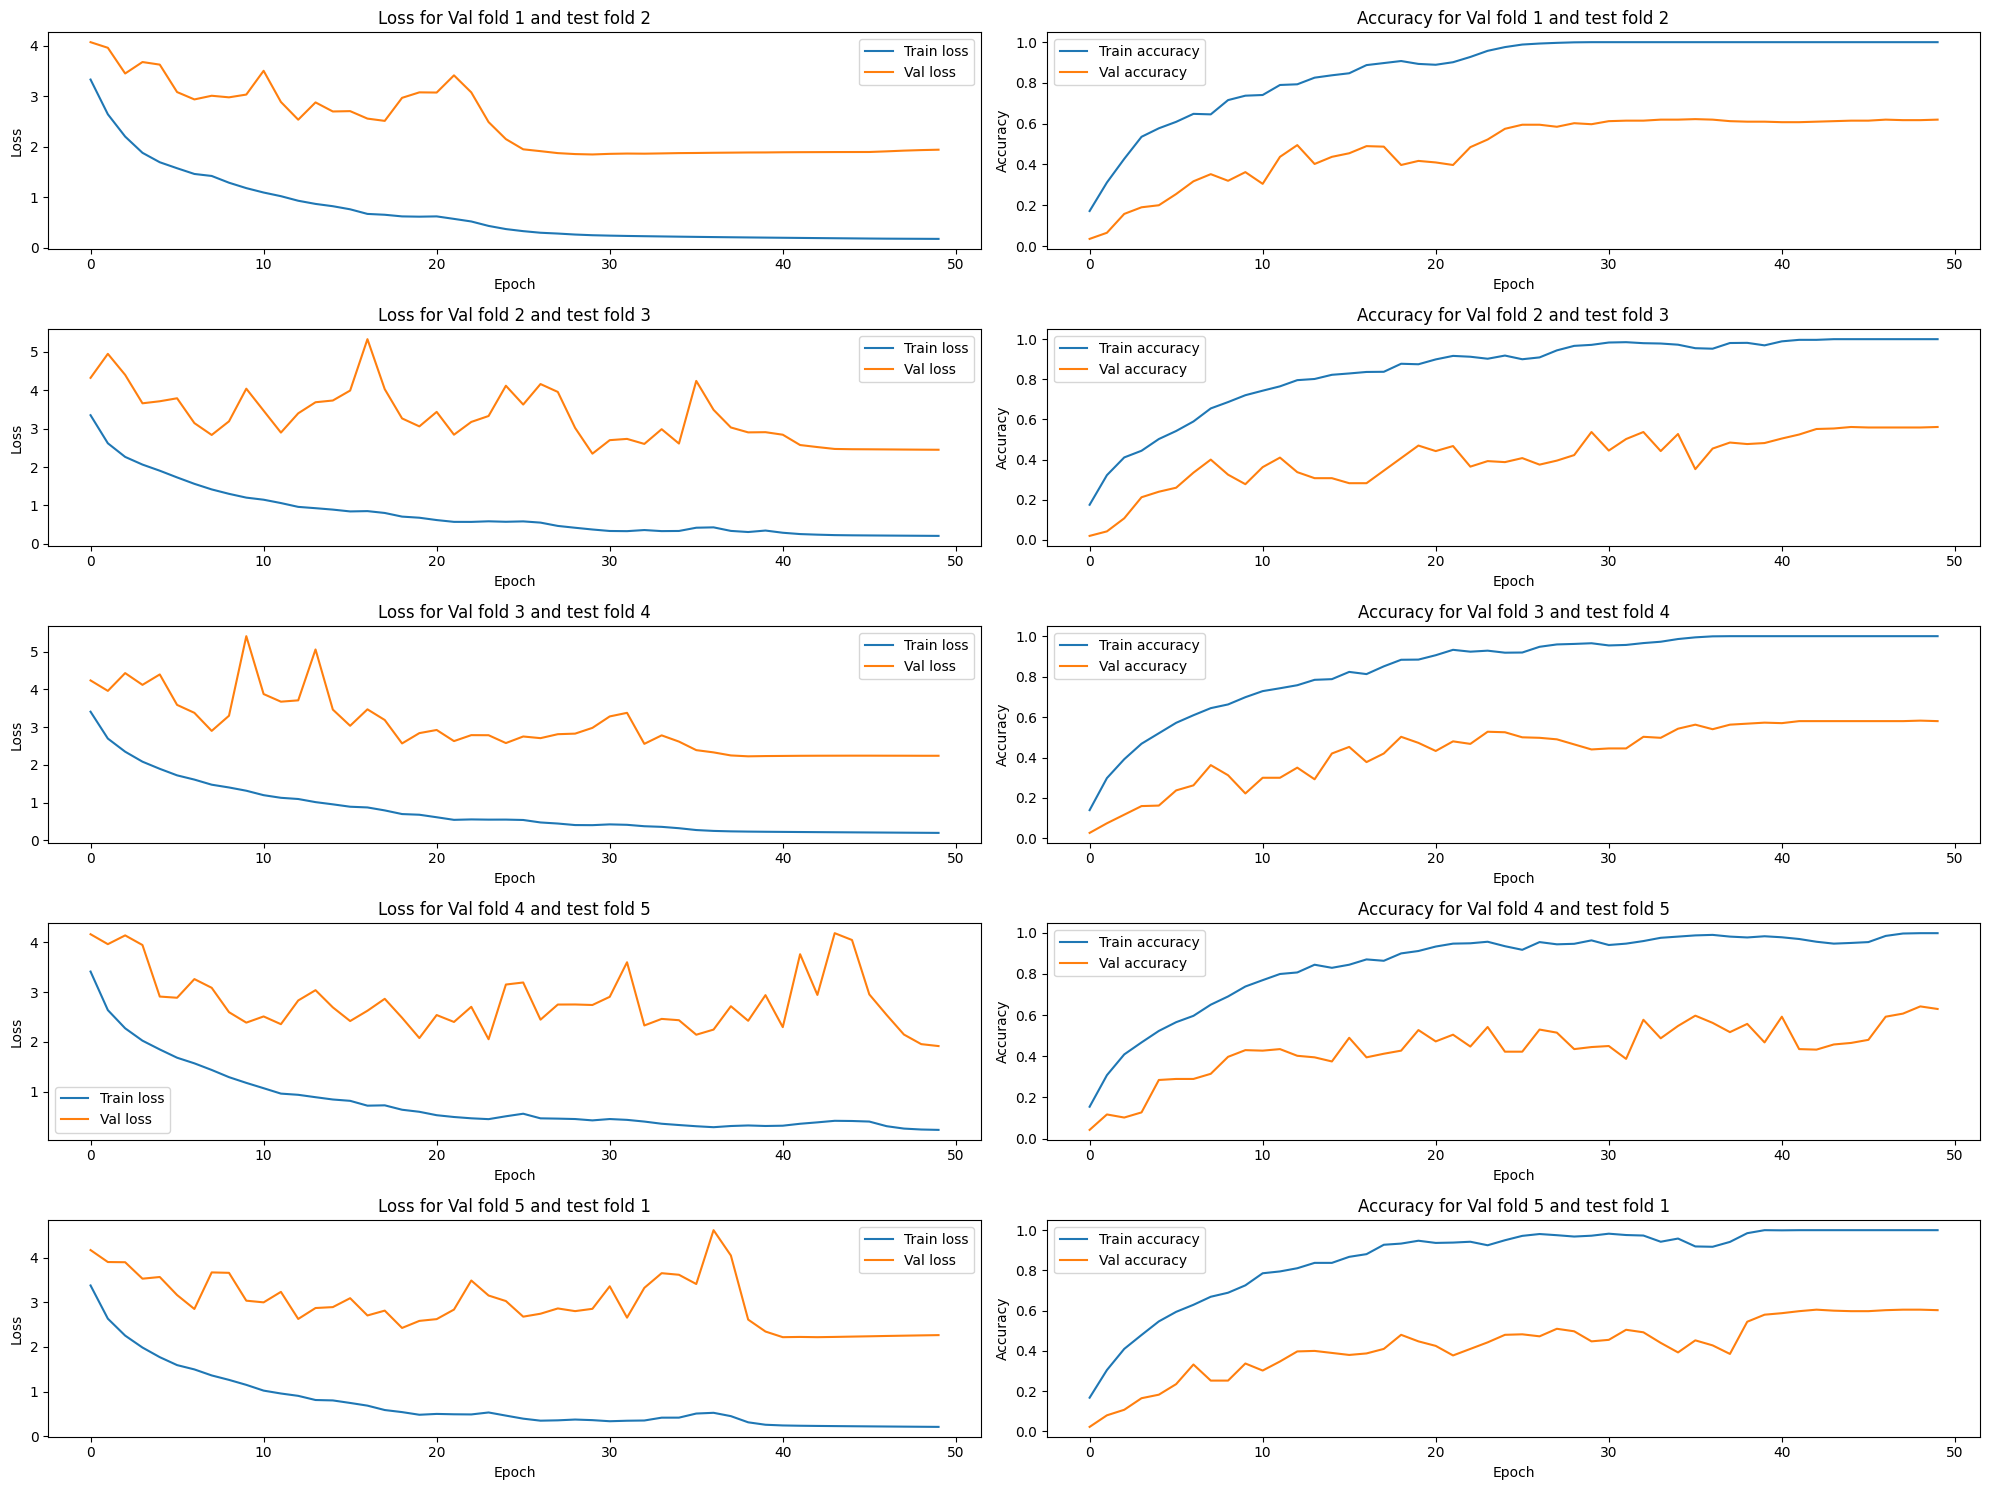

In [ ]:
#Training and evaluation of the RawNet on the standard dataset
rawnet_accuracy, rawnet_time, y_test, rawnet_preds = train_and_evaluate(m11,input_shape=(110250,1),type_input="raw_audio")

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 0.6800, Accuracy: 0.8710, Val Loss: 3.1596, Val Accuracy: 0.4750
Epoch 20 - Loss: 0.4477, Accuracy: 0.9505, Val Loss: 3.2687, Val Accuracy: 0.5200
Epoch 30 - Loss: 0.4213, Accuracy: 0.9508, Val Loss: 4.9443, Val Accuracy: 0.4825

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 40 - Loss: 0.2031, Accuracy: 0.9998, Val Loss: 2.8905, Val Accuracy: 0.6225

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 50 - Loss: 0.1599, Accuracy: 1.0000, Val Loss: 2.9419, Val Accuracy: 0.6375
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Fold 2 - Test Accuracy: 0.6100000143051147
Processing Fold 2 - Validation Fold: 2, Test Fold: 3
Epoch 10 - Loss: 0.7065, Accuracy: 0.8613, Val Loss: 3.0242, Val Accuracy: 0.4400
Epoch 20 - Loss: 0.4434, Accuracy: 0.9467, Val Loss: 3.8164, Val Accuracy: 0.4300
Epoch 30 - Loss: 0.3575, Accuracy: 0.9705, Val Loss: 3.9679, Val Accuracy: 0.4550

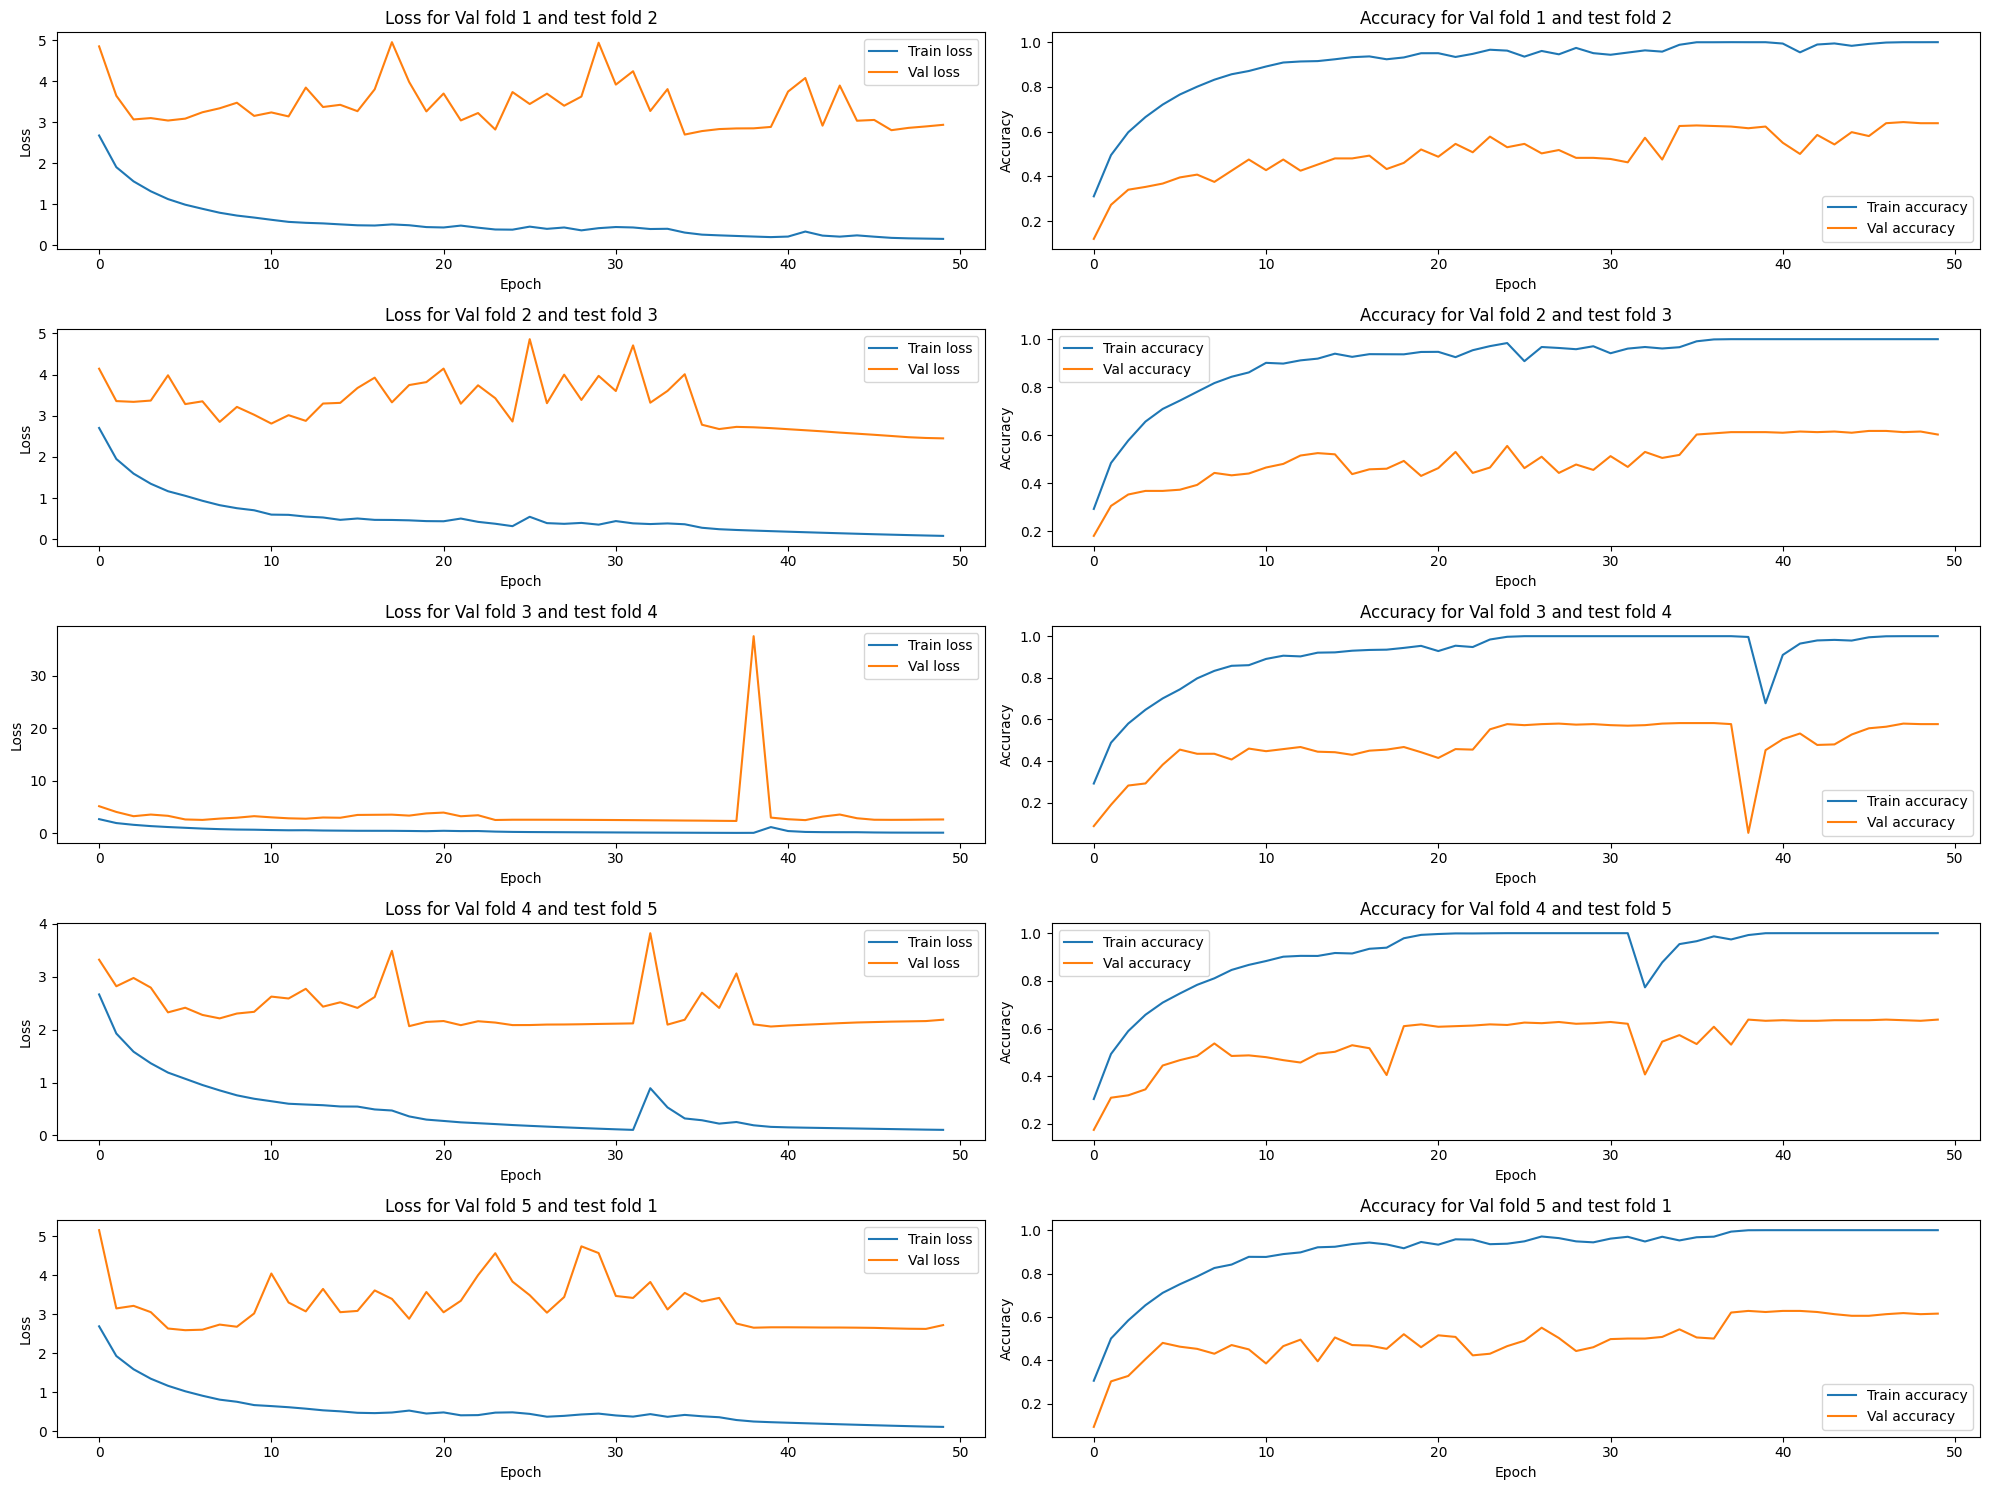

In [ ]:
#Training and evaluation of the RawNet on the pitch-shifted dataset
rawnet_accuracy_pitch, rawnet_time_pitch, y_test, rawnet_preds_pitch = train_and_evaluate(m11,input_shape=(110250,1),type_input="raw_audio")

## CRNN model on log-mel spectrograms

In [ ]:
def CRNN(input_shape, variant):
    X_input = tf.keras.Input(input_shape)

    # Convolutional layers
    # First Convolutional Layer
    X = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(X_input)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D((2, 2))(X)

    # Second Convolutional Layer
    X = tf.keras.layers.Conv2D(128, (3, 3), padding="same")(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D((2, 2))(X)

    # Third Convolutional Layer
    X = tf.keras.layers.Conv2D(256, (3, 3), padding="same")(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D((2, 2))(X)

    #Fourth Convolutional Layer
    X = tf.keras.layers.Conv2D(256, (3, 3), padding="same")(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.MaxPool2D((2, 2))(X)

    # Global Max Pooling over the time dimension
    # Starting from shape (batch_size, num_frequency, time, channels)
    X = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=2))(X)  #(batch_size, frequency, channels)
    X = tf.keras.layers.Reshape((X.shape[1], X.shape[2]))(X)
    # Bidirectional GRU layers
    X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True))(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256))(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    # Output layer for classification
    if variant == 'ESC-10':
        X = tf.keras.layers.Dense(units=10, activation='softmax')(X)
    else:
        X = tf.keras.layers.Dense(units=50, activation='softmax')(X)
    # Define the model
    model = tf.keras.Model(inputs=X_input, outputs=X, name="CRNN")
    return model

# Instantiate the model
CRNN_model = CRNN((60, 216, 2), 'ESC-50')
CRNN_model.summary()

Model: "CRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 216, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 60, 216, 64)    │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 216, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 60, 216, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 108, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 30, 108, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 54, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 54, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 15, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 27, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 27, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 7, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 3, 512)         │       789,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │     1,182,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             

 Total params: 2,961,010 (11.30 MB)

 Trainable params: 2,959,602 (11.29 MB)

 Non-trainable params: 1,408 (5.50 KB)

Processing Fold 1 - Validation Fold: 1, Test Fold: 2
Epoch 10 - Loss: 0.8150, Accuracy: 0.9158, Val Loss: 1.0579, Val Accuracy: 0.6950
Epoch 20 - Loss: 0.6929, Accuracy: 0.9475, Val Loss: 1.5764, Val Accuracy: 0.5775
Epoch 30 - Loss: 0.6586, Accuracy: 0.9545, Val Loss: 1.2384, Val Accuracy: 0.6450

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 40 - Loss: 0.5708, Accuracy: 0.9667, Val Loss: 0.9515, Val Accuracy: 0.7350

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 50 - Loss: 0.5582, Accuracy: 0.9654, Val Loss: 0.9811, Val Accuracy: 0.7425
Epoch 60 - Loss: 0.5430, Accuracy: 0.9683, Val Loss: 0.9283, Val Accuracy: 0.7700
Epoch 70 - Loss: 0.5319, Accuracy: 0.9615, Val Loss: 0.9290, Val Accuracy: 0.7600
Epoch 80 - Loss: 0.5151, Accuracy: 0.9680, Val Loss: 0.9897, Val Accuracy: 0.7550
Epoch 90 - Loss: 0.5161, Accuracy: 0.9657, Val Loss: 0.9889, Val Accuracy: 0.7375
Epoch 100 - Loss: 0.5009, Accuracy: 0.9683, Val Loss: 1.0157, Val A

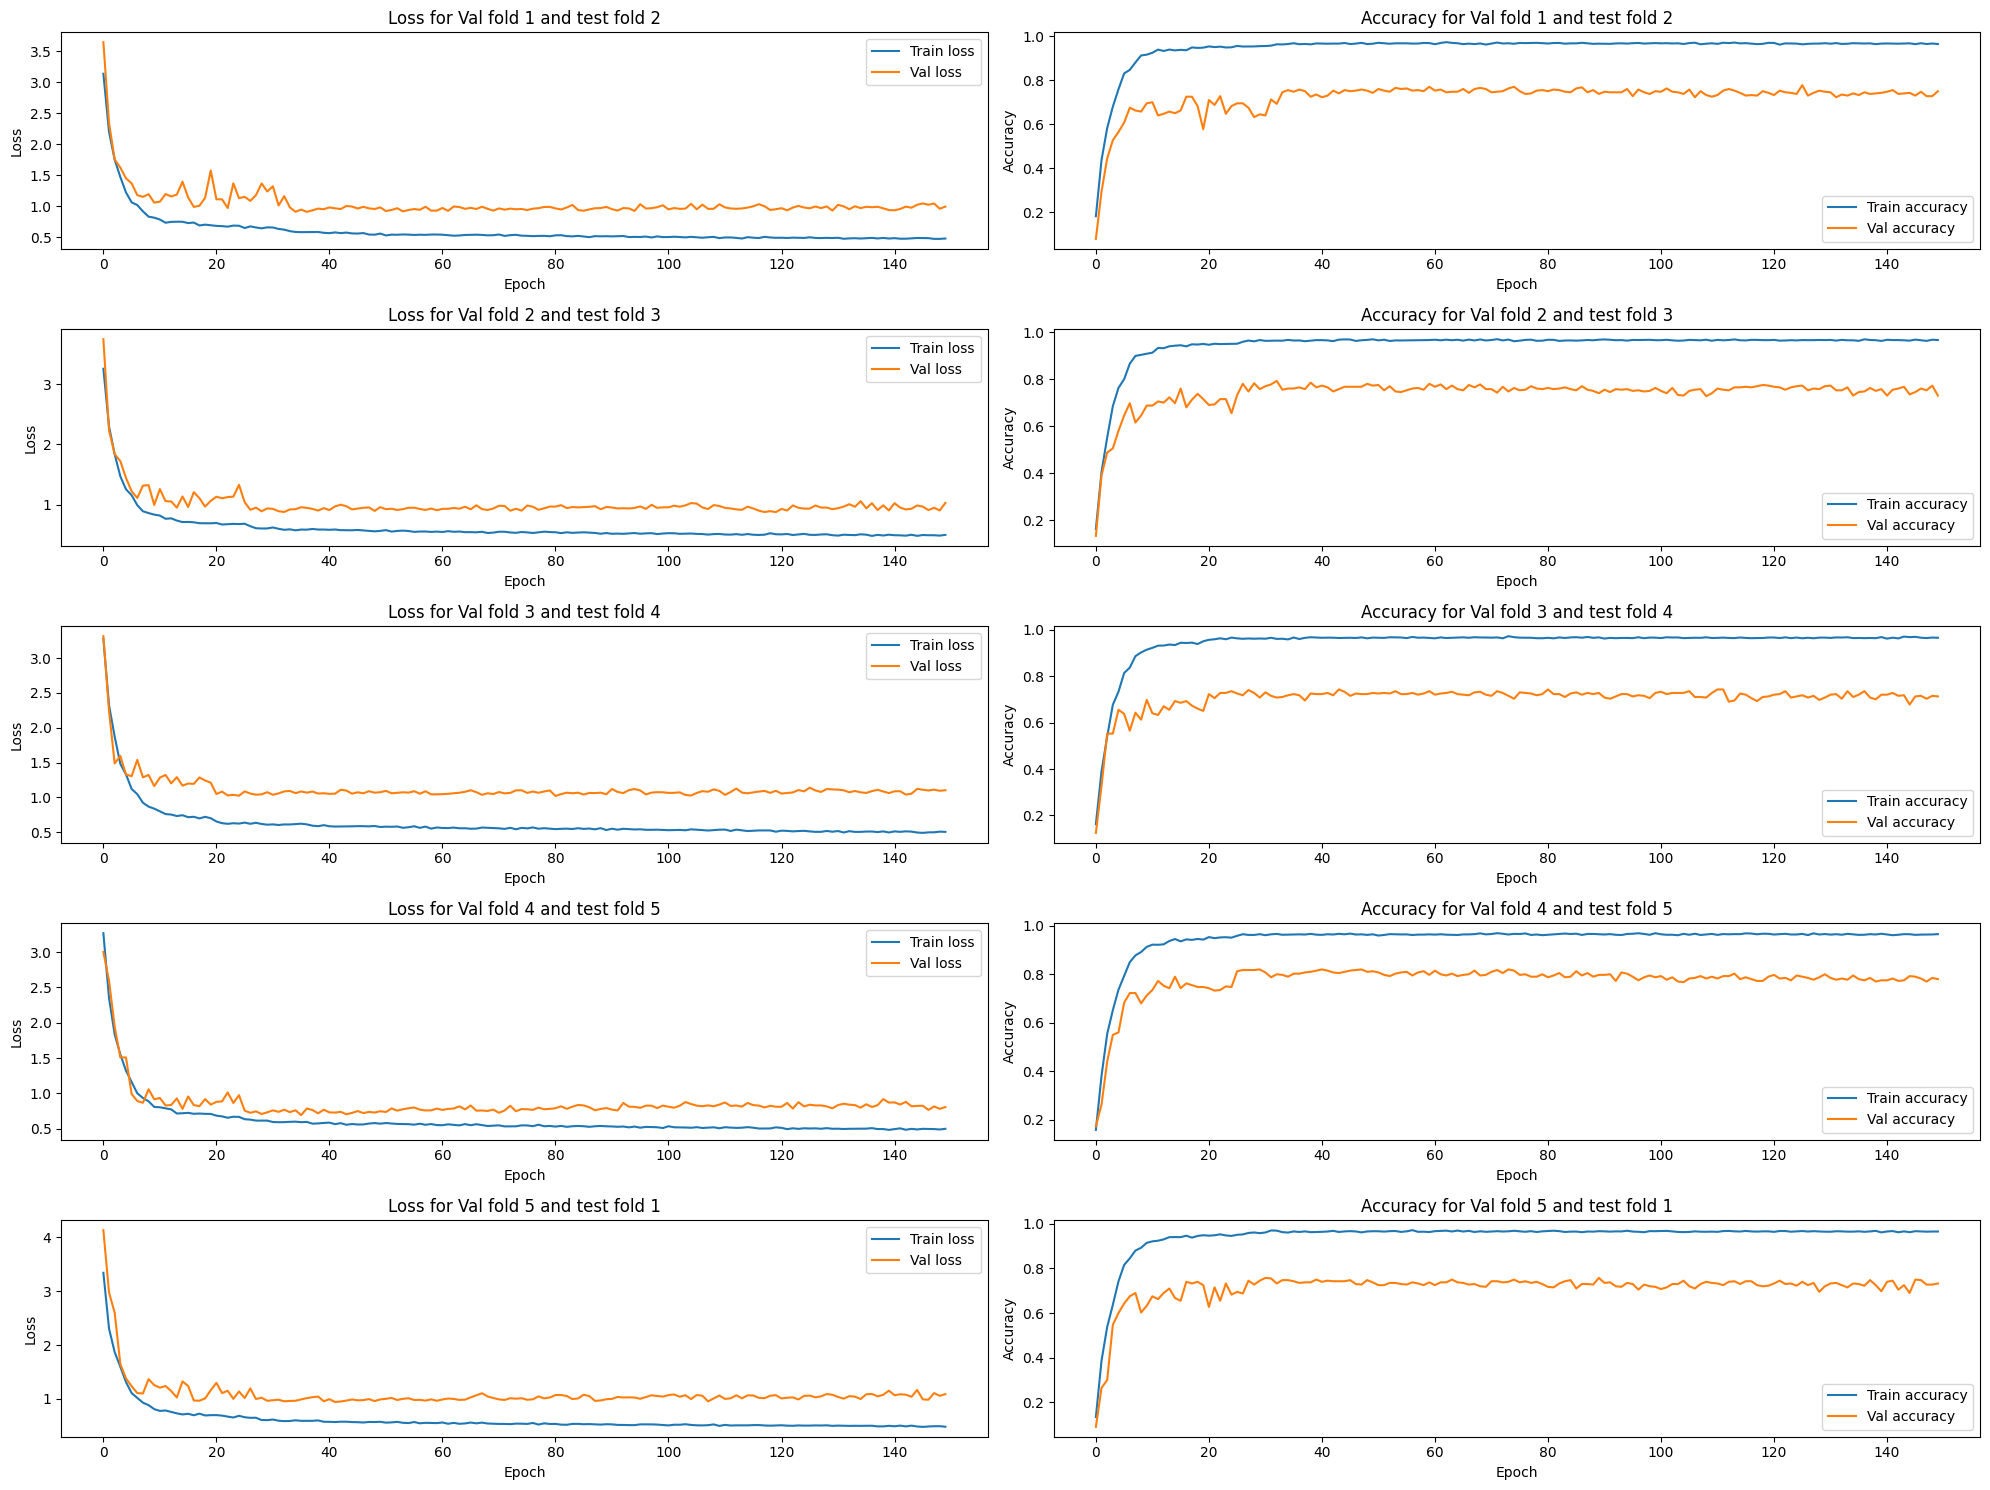

In [ ]:
#Training and evaluation of CRNN model with mix up augmentation
crnn_accuracy, crnn_time, y_test, crnn_preds = train_and_evaluate(CRNN,input_shape=(60,216,2),type_input = "melspec", mixup=True)

In [ ]:
np.save("mfccnet_preds.npy", mfccnet_preds)
np.save("crnn_preds.npy", crnn_preds)

rawnet_preds = np.load("/kaggle/input/predictions/rawnet_preds.npy")
mfccnet_preds = np.load("/kaggle/input/predictions/mfccnet_preds.npy")
melnet_preds = np.load("/kaggle/input/predictions/preds_mix.npy")
crnn_preds = np.load("/kaggle/input/crnn-predictions/crnn_preds.npy")
y_test = np.load("/kaggle/input/true-labels/y_test.npy")


## Evaluation of the models tested

In [ ]:
# Convert probabilities to class labels
rawnet_labels = np.argmax(rawnet_preds, axis=2)
mfccnet_labels = np.argmax(mfccnet_preds, axis=2)
melnet_labels = np.argmax(melnet_preds, axis=2)
crnn_labels = np.argmax(crnn_preds, axis=2)

# Calculate precision, recall, accuracy, and F1 score for each fold
def evaluate_model_cv(y_true, y_pred, model_name):
    accuracies = []
    precisions = []
    f1_scores = []

    # Calculate metrics for each fold
    for fold in range(y_true.shape[0]):
        accuracy = accuracy_score(y_true[fold], y_pred[fold])
        precision = precision_score(y_true[fold], y_pred[fold], average='macro', zero_division=0)
        f1 = f1_score(y_true[fold], y_pred[fold], average='macro', zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        f1_scores.append(f1)

    # Calculate mean and std for each metric
    print(f"{model_name} - Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"{model_name} - Mean Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"{model_name} - Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

In [ ]:
evaluate_model_cv(y_test, melnet_labels, "MelNet")

MelNet - Mean Accuracy: 0.7140 ± 0.0240
MelNet - Mean Precision: 0.7505 ± 0.0267
MelNet - Mean F1 Score: 0.7050 ± 0.0317


In [ ]:
evaluate_model_cv(y_test, rawnet_labels, "RawNet")

RawNet - Mean Accuracy: 0.6095 ± 0.0317
RawNet - Mean Precision: 0.6284 ± 0.0361
RawNet - Mean F1 Score: 0.5979 ± 0.0325


In [ ]:
evaluate_model_cv(y_test, mfccnet_labels, "MFCCNet")

MFCCNet - Mean Accuracy: 0.6570 ± 0.0357
MFCCNet - Mean Precision: 0.7161 ± 0.0319
MFCCNet - Mean F1 Score: 0.6488 ± 0.0389


In [ ]:
evaluate_model_cv(y_test, crnn_labels, "CRNN")

CRNN - Mean Accuracy: 0.7480 ± 0.0261
CRNN - Mean Precision: 0.7699 ± 0.0314
CRNN - Mean F1 Score: 0.7396 ± 0.0281


## Ensemble models

In [ ]:
def ensamble(type_ensemble):
    accuracies = []
    precisions=[]
    f1_scores =[]
    for fold in range(5):
        # Average predictions from all the models for the current fold
        if type_ensemble == "Average":
            ensemble_pred_fold = (rawnet_preds[fold] + melnet_preds[fold] + mfccnet_preds[fold] + crnn_preds[fold]) / 4
        elif type_ensemble == "Product":
            ensemble_pred_fold = rawnet_preds[fold] * melnet_preds[fold] *mfccnet_preds[fold] * crnn_preds[fold]
        # Get predicted classes
        predicted_classes = np.argmax(ensemble_pred_fold, axis=1)  # Shape: (400,)
        true_labels = y_test[fold]

        # Compute accuracy for the current fold
        acc = accuracy_score(true_labels, predicted_classes)
        prec = precision_score(true_labels, predicted_classes, average="macro")
        f1 = f1_score(true_labels, predicted_classes, average="macro")

        accuracies.append(acc)
        precisions.append(prec)
        f1_scores.append(f1)

    # Compute the average accuracy across all folds
    ensemble_accuracy = np.mean(accuracies)
    ensemble_precision = np.mean(precisions)
    ensemble_f1 = np.mean(f1_scores)

    ensemble_accuracy_std = np.std(accuracies)
    ensemble_precision_std = np.std(precisions)
    ensemble_f1_std = np.std(f1_scores)

    print(f"{type_ensemble} Ensemble Accuracy Across Folds: {ensemble_accuracy:.4f} ± {ensemble_accuracy_std:.4f}")
    print(f"{type_ensemble} Ensemble Precision Across Folds: {ensemble_precision:.4f} ± {ensemble_precision_std:.4f}")
    print(f"{type_ensemble} Ensemble F1-score Across Folds: {ensemble_f1:.4f} ± {ensemble_f1_std:.4f}")

    return

## Ensamble Average

In [ ]:
ensamble("Average")

Average Ensemble Accuracy Across Folds: 0.7865 ± 0.0224
Average Ensemble Precision Across Folds: 0.8067 ± 0.0247
Average Ensemble F1-score Across Folds: 0.7767 ± 0.0258


## Ensable Product

In [ ]:
ensamble("Product")

Product Ensemble Accuracy Across Folds: 0.7910 ± 0.0287
Product Ensemble Precision Across Folds: 0.8113 ± 0.0296
Product Ensemble F1-score Across Folds: 0.7825 ± 0.0318
